In [1]:

# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from xgboost import XGBClassifier

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter
from modAL.models import ActiveLearner, Committee

import copy

from sklearn.datasets import make_classification
from alipy import ToolBox
from alipy.utils.misc import nsmallestarg, randperm, nlargestarg

/home/vincent/git_repos/NA_Model_Evaluation/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score

#graph
import seaborn as sns
import matplotlib.pyplot as plt

# Data Processing and Functions

In [72]:
def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == "BENIGN"])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 'BENIGN'], 
                                curr_df[curr_df['Label'] != 'BENIGN'].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 'BENIGN'], 
                                curr_df[curr_df['Label'] == 'BENIGN'].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "BENIGN"].shape[0] / sampled_df.loc[sampled_df["Label"] != "BENIGN"].shape[0]
    
    return sampled_df

def process_dataset(curr_df, anomaly_rate, train_perc = 0.85, split=True):

    improved_df = curr_df.copy()

    # Clean the labels
    attempted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    if attempted_labels:
        improved_df.drop(['Attempted Category'], axis=1, inplace=True)
        improved_df.replace(attempted_labels, 'BENIGN', inplace=True)

    # Filter and sample the DataFrame
    
    improved_df = sample_df(improved_df, anomaly_rate)
    # Dataset preparation
    if split == False:
        return improved_df
    Y = improved_df['Label'].map({"BENIGN": 0}).fillna(1)
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    
    dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp', 'Dvc Label']    
    scaler = StandardScaler()
    scaler.fit(X.drop(columns=dropping_cols, axis=1, inplace=False))

    train_perc = 0.15

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        Y, 
                                                        test_size=1 - train_perc, 
                                                        shuffle=True, 
                                                        stratify=Y, 
                                                        random_state=42)
    
        
    return X_train, X_test, y_train, y_test, scaler
def set_supervised_label(supervision_rate, y, idx):
        if supervision_rate == 0:
            y[idx[:2]] = 1
        else:
            idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False)
            y[idx] = 1
        return y
            
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
            
def perform_inference(X_test, y_test, dropping_cols, scaler, clf, curr_ip=None):
    if curr_ip:
        curr_X_test = X_test.loc[X_test["Dvc Label"] == curr_ip].copy()
        curr_y_test = y_test.loc[X_test["Dvc Label"] == curr_ip].copy()
    else:
        curr_X_test = X_test.copy()
        curr_y_test = y_test.copy()
    # curr_X_test.drop(dropping_cols, axis = 1, inplace = True)     
    curr_X_test_scaled = scaler.transform(curr_X_test)
    # Evaluate the model
    anomaly_scores = clf.decision_function(X=curr_X_test_scaled)
    fpr, tpr, _ = roc_curve(curr_y_test, anomaly_scores)
    # Get Labels for Local Model
    precision, recall, thresholds = precision_recall_curve(curr_y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    # opt_threshold = 2.594822645187378
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    roc_auc = auc(fpr, tpr)    
    return roc_auc, curr_X_test_scaled, pred, opt_threshold

def plot_graph_scenario(metrics_dict, queries_iter, title=""):
        fig, axes = plt.subplots(1,1,figsize=(14, 8))  # Create a figure and a set of subplots.
        ax_n = 0
        metric_type = "metric"
    # for metric_type in metrics_dict:
        curr_ax = axes
        ax_n +=1

        # Assuming metrics_dict['roc_auc'] contains the ROC AUC values for each IP
        ips = list(metrics_dict[metric_type].keys())
        n_ips = len(ips)
        n_queries = len(queries_iter)

        # Create a numpy array to hold the ROC AUC values
        roc_aucs = np.zeros((n_ips, n_queries))
        
        for i, ip in enumerate(ips):
            for j, sr in enumerate(queries_iter):
                if isinstance(metrics_dict[metric_type][ip][sr], list):
                    # Extract the first element if it's a list
                    print(ip, sr, metrics_dict[metric_type][ip][sr])
                roc_aucs[i, j] = metrics_dict[metric_type][ip][sr]
                

        # Create the bar width
        bar_width = 0.15
        index = np.arange(n_ips)

        # Plot bars for each supervision rate
        for j, sr in enumerate(queries_iter):
            curr_ax.bar(index + j * bar_width, roc_aucs[:, j], bar_width, label=f'Query Num: {sr}')
        curr_ax.set_title(title)
        curr_ax.set_xlabel('IP Address')
        curr_ax.set_ylabel('AUC')
        curr_ax.set_xticks(index + bar_width * (n_queries - 1) / 2)
        curr_ax.set_xticklabels(ips, rotation=45)
        curr_ax.legend()
        curr_ax.grid(True)
        curr_ax.set_ylim(0.6,1.05)
        plt.tight_layout()
        plt.show()

In [4]:
new_victim_df = pd.read_csv("new_victim_df.csv")
new_victim_df.drop(columns=["Unnamed: 0"], inplace=True)

In [5]:
new_victim_df

,id,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label,Dvc Label
0,2,192.168.10.9-192.168.10.3-123-123-17,192.168.10.9,123,192.168.10.3,123,17,2017-07-03 11:56:55.428911,65511209,6,...,1506210,64004884.0,0.000000e+00,64004884,64004884,0,0,0,BENIGN,192.168.10.9c
1,3,192.168.10.12-224.0.0.251-5353-5353-17,192.168.10.12,5353,224.0.0.251,5353,17,2017-07-03 11:57:21.057686,113976922,267,...,14,25498178.0,1.883305e+07,48523116,5463561,0,0,0,BENIGN,192.168.10.12b
2,4,192.168.10.12-152.2.133.52-123-123-17,192.168.10.12,123,152.2.133.52,123,17,2017-07-03 11:57:31.568196,67037196,8,...,11034681,55956316.0,0.000000e+00,55956316,55956316,0,0,0,BENIGN,192.168.10.12b
3,5,192.168.10.12-45.79.11.217-123-123-17,192.168.10.12,123,45.79.11.217,123,17,2017-07-03 11:57:30.571719,68045057,8,...,11043596,56943904.0,0.000000e+00,56943904,56943904,0,0,0,BENIGN,192.168.10.12a
4,6,192.168.10.12-91.189.89.198-123-123-17,192.168.10.12,123,91.189.89.198,123,17,2017-07-03 11:57:32.600148,70053281,3,...,3054960,66904116.0,0.000000e+00,66904116,66904116,0,0,0,BENIGN,192.168.10.12a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669931,547553,172.16.0.1-192.168.10.50-64318-2222-6,172.16.0.1,64318,192.168.10.50,2222,6,2017-07-07 18:09:11.499555,64,1,...,0,0.0,0.000000e+00,0,0,0,0,64,Portscan,192.168.10.50c
1669932,547554,172.16.0.1-192.168.10.50-33248-9040-6,172.16.0.1,33248,192.168.10.50,9040,6,2017-07-07 17:54:38.857717,76,1,...,0,0.0,0.000000e+00,0,0,0,0,76,Portscan,192.168.10.50b
1669933,547555,172.16.0.1-192.168.10.50-44033-1272-6,172.16.0.1,44033,192.168.10.50,1272,6,2017-07-07 17:52:03.285040,81,1,...,0,0.0,0.000000e+00,0,0,0,0,81,Portscan,192.168.10.50b
1669934,547556,192.168.10.16-192.168.10.3-64748-53-17,192.168.10.16,64748,192.168.10.3,53,17,2017-07-07 18:33:45.701233,297,2,...,0,0.0,0.000000e+00,0,0,0,0,0,BENIGN,192.168.10.16b


<Axes: title={'center': 'All Counts'}>

Text(0.5, 0, 'Victim IP')

Text(0, 0.5, 'Count')

<Axes: title={'center': 'Sampled Counts'}>

Text(0.5, 0, 'Victim IP')

Text(0, 0.5, 'Count')

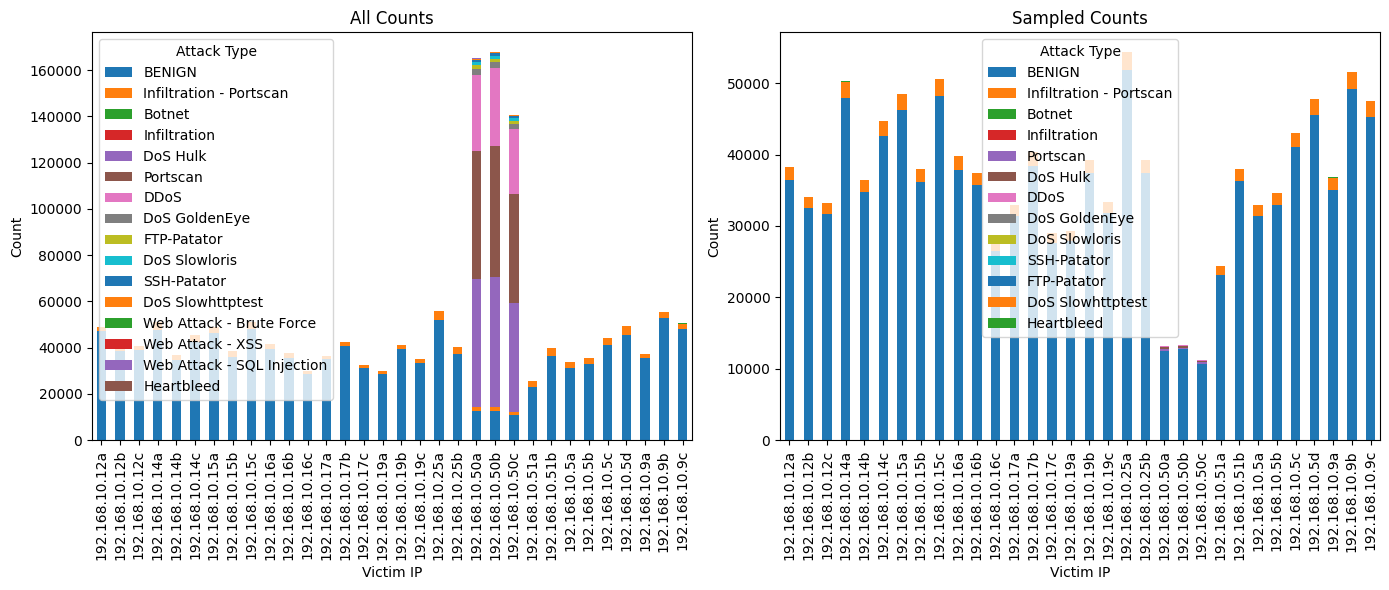

In [6]:
new_victim_IP = new_victim_df["Dvc Label"].value_counts().keys()
new_victim_IP = new_victim_IP.sort_values()
all_counts = pd.DataFrame()
sampled_all_counts = pd.DataFrame()
for curr_ip in new_victim_IP:
    curr_ip_df = new_victim_df.loc[new_victim_df["Dvc Label"] == curr_ip]
    counts = curr_ip_df["Label"].value_counts()
    counts.name = curr_ip
    all_counts = pd.concat([all_counts, counts], axis=1)
    
    sampled_curr_ip_df = sample_df(curr_ip_df, anomaly_rate=0.05)
    counts = sampled_curr_ip_df["Label"].value_counts()
    counts.name = curr_ip
    sampled_all_counts = pd.concat([sampled_all_counts, counts], axis=1)
        
all_counts = all_counts.T
all_counts.sort_index(inplace=True)
sampled_all_counts = sampled_all_counts.T
sampled_all_counts.sort_index(inplace=True)


# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Correct subplot usage

# Plot on the first subplot
all_counts.plot(kind='bar', stacked=True, ax=ax[0], title='All Counts')
ax[0].set_xlabel("Victim IP")
ax[0].set_ylabel("Count")
ax[0].legend(title="Attack Type")

# Plot on the second subplot
sampled_all_counts.plot(kind='bar', stacked=True, ax=ax[1], title='Sampled Counts')
ax[1].set_xlabel("Victim IP")
ax[1].set_ylabel("Count")
ax[1].legend(title="Attack Type")

plt.tight_layout()
plt.show()


<Figure size 100x200 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Frequency of Each Label in Dataset')

(array([0]), [Text(0, 0, 'count')])

<Figure size 100x200 with 0 Axes>

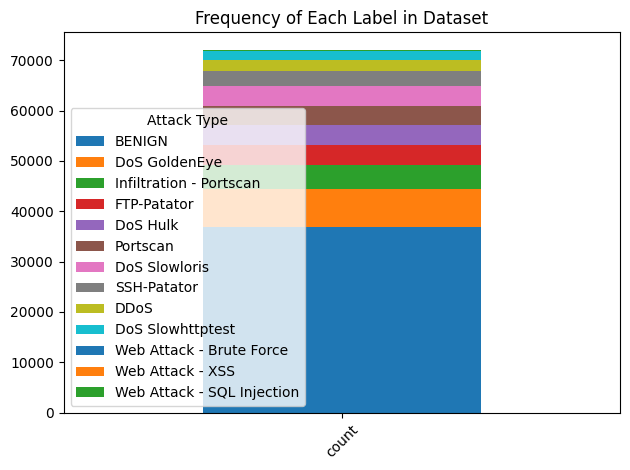

In [7]:
new_atk_df = new_victim_df.loc[(new_victim_df["Dvc Label"] == "192.168.10.50a") | 
                               (new_victim_df["Dvc Label"] == "192.168.10.50b") |
                               (new_victim_df["Dvc Label"] == "192.168.10.50c")]
benign_df = new_atk_df[new_atk_df["Label"] == "BENIGN"].sample(frac=1.0, random_state=42)
misc_atk_df = new_atk_df.loc[(new_atk_df["Label"] != "DDoS") &
                             (new_atk_df["Label"] != "DoS Hulk") &
                             (new_atk_df["Label"] != "Portscan") &
                             (new_atk_df["Label"] != "BENIGN") ].sample(frac=1.0, random_state=42)

common_atk_df = new_atk_df.loc[(new_atk_df["Label"] == "DDoS") |
                             (new_atk_df["Label"] == "DoS Hulk") |
                             (new_atk_df["Label"] == "Portscan") |
                             (new_atk_df["Label"] == "BENIGN") ].sample(frac=1.0, random_state=42)

new_atk_df = pd.concat([benign_df, misc_atk_df, common_atk_df[:benign_df.shape[0] - misc_atk_df.shape[0]]])

label_counts = new_atk_df["Label"].value_counts()
label_counts_df = pd.DataFrame(label_counts).T
# Plotting
plt.figure(figsize=(1, 2))
label_counts_df.plot(kind='bar', stacked=True)
plt.title('Frequency of Each Label in Dataset')
plt.xticks(rotation=45)
plt.legend(title="Attack Type")
plt.tight_layout()
plt.show()

## Performace New Attack

In [8]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling

def lm_eval_2(Xgmm_test_dvc, gm_pred, lm_clf):
    train_perc = 0.6
    Xlm_train, Xlm_test, ylm_train, ylm_test = train_test_split(Xgmm_test_dvc, 
                                                        gm_pred, 
                                                        test_size=1 - train_perc, 
                                                        shuffle=True, 
                                                        stratify=gm_pred, 
                                                        random_state=42)    
    if lm_clf == "Comittee":
        # initializing Committee members
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):

            # initializing learner
            learner = ActiveLearner(
                estimator=RandomForestClassifier(),
                X_training=Xlm_train, y_training=ylm_train,
            )
            learner_list.append(learner)        
        lm_clf = Committee(learner_list=learner_list)
        predictions = lm_clf.predict(Xlm_test)    
    else:
        # Train the classifier on the training data
        lm_clf.fit(Xlm_train, ylm_train)    
        
        predictions = lm_clf.predict(Xlm_test)

        
    # Evaluate accuracy
    accuracy = accuracy_score(ylm_test, predictions)
    print(f"Accuracy: {accuracy}")
    return accuracy, lm_clf, Xlm_train, ylm_train
# Read the csv and clean it
def train_gm(Xgm_train_scaled, y_train, supervision_rate, model):

    # Prepare labels for semi-supervised learning
    idx = np.where(y_train == 1)[0]
    y = np.zeros_like(y_train.values)
    y = set_supervised_label(supervision_rate, y, idx)
    # Train the model
    path = f"gm_1_{supervision_rate}.pkl"
    if os.path.exists(path):
        with open(path, 'rb') as f:
            clf = pickle.load(f)
    else:
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=Xgm_train_scaled.to_numpy(), y=y_train)  
            
            # with open(path, 'wb') as f:
                # pickle.dump(clf, f)
    return clf
def train_lm(victim_IP, Xgmm_test, y_test, scaler, gm_clf,lm_clf, method = "Normal"):
    # Load Model Instead      
    # dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
    #                 'Dst Port', 'Timestamp', 'Dvc Label']            
    # Create a fresh copy of the DataFrame for each IP and supervision rate
    roc_auc, curr_X_test_scaled, gm_pred, gm_opt_threshold = perform_inference(Xgmm_test, y_test, dropping_cols, scaler, gm_clf)
    print(f"gm_opt_threshold is {gm_opt_threshold}")
    acc, updated_lm_clf, Xlm_train, Ylm_train = lm_eval_2(curr_X_test_scaled, gm_pred, lm_clf)
    return updated_lm_clf, gm_opt_threshold, Xlm_train, Ylm_train



# Perform New Attack Classification using Local Model (Obtain)
def new_attacks_inference(lm_clf, Xnew_train, ynew_train, scaler):

        cart_predictions = lm_clf.predict(Xnew_train)
        # Evaluate accuracy
        accuracy = accuracy_score(ynew_train, cart_predictions)
        print(f"Accuracy before update: {accuracy}")
        
        # Get Confidence Point
        # Get the indices of the samples where the actual label doesn't match the predicted label
        mismatch_indices = [i for i, (actual, cart_predictions) in enumerate(zip(ynew_train, cart_predictions)) if actual != cart_predictions]

        uncertain_count = 0
        cart_probabilities = lm_clf.predict_proba(Xnew_train)

        return accuracy, cart_probabilities, mismatch_indices 

def active_learning_query(lm_clf, Xnew_train, ynew_train, scaler):
    pass
    #Use Stream-Based Sampling, however instead of 1 by 1, get the whole pool

        # X_pool = Xnew_train.copy()
        # y_pool = ynew_train.copy()
        # for idx in range(n_queries):
        #     query_idx, query_instance = lm_clf.query(X_pool)
        #     lm_clf.teach(
        #         X=X_pool[query_idx].reshape(1, -1),
        #         y=y_pool[query_idx].reshape(1, )
        #     )
        #     performance_history.append(lm_clf.score())
        #     # remove queried instance from pool
        #     X_pool = np.delete(X_pool, query_idx, axis=0)
        #     y_pool = np.delete(y_pool, query_idx)     
        # predictions = lm_clf.predict(X_pool)     
        
    

# Forward Low confidence data to GM and Label (Get GM Accuracy)
def get_low_confidence_data(cart_probabilities, mismatch_indices, threshold=1):
    if threshold == 1:
        forward_gm_idx = np.where((cart_probabilities[:, 0] != threshold) & (cart_probabilities[:, 0] !=  threshold))
    else: 
        forward_gm_idx = np.where((cart_probabilities[:, 0] > threshold) & (cart_probabilities[:, 0] <  1-threshold))
    print(f"Total Uploaded Data {len(forward_gm_idx[0])}")
    # How many Misclassified data is inconfident
    set_mismatch_indices = set(list(mismatch_indices))
    set_forward_gm_idx = set(forward_gm_idx[0].tolist())
    x = len(set_mismatch_indices.intersection(set_forward_gm_idx))
    print(f"Percentage of misclassied data that is uploaded: {x/len(mismatch_indices)}")
    print(f"Total Data Uploaded: {len(forward_gm_idx[0])/len(cart_probabilities)}")
    # print(f"Correctly Detected / Uploaded data: {(x/len(forward_gm_idx[0]))}")  
    return forward_gm_idx

# Upload to label and Perform Training on CART_Classifier
def upload_gm(X_forward, y_forward, gm_clf, lm_clf, gm_opt_threshold, orig_Xlm_train, orig_Ylm_train):
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    initial_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, initial_gm_pred)
    print(f'Accuracy of GM before update: {accuracy}')
    
    # Convert numpy arrays to DataFrames
    X_forward_df = pd.DataFrame(X_forward, columns = orig_Xlm_train.columns )
    y_forward_df = pd.DataFrame(np.zeros(initial_gm_pred.shape[0]), columns=["Label"])

    # Concatenate with original DataFrames
    Xtrain = pd.concat([pd.DataFrame(orig_Xlm_train), X_forward_df], axis=0)
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), y_forward_df])
    Xtrain.columns = orig_Xlm_train.columns
    # return Xtrain, Ytrain
    # Update GM
    gm_clf = train_gm(orig_Xlm_train, orig_Ylm_train, supervision_rate, PReNet)
    # Inference using updated GM
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    updated_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, updated_gm_pred)
    print(f'Accuracy of GM after update: {accuracy}')  
    
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), pd.DataFrame(updated_gm_pred, columns=["Label"])])  
    lm_clf = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1)
    # continued_model.fit(X_forward_df, y_forward_df, xgb_model=lm_clf.get_booster())    
    # continued_model.fit(Xtrain, Ytrain)
    lm_clf.fit(Xtrain, Ytrain)
    return lm_clf
# Evaluate Accuracy with new attack data
def eval_updated_lm(Xnew_test, ynew_test, new_lm_clf):
    pred = new_lm_clf.predict(Xnew_test)
    acc = accuracy_score(ynew_test, pred)
    print(f'Accuracy of updated LM: {acc}')


## Alipy Active Learning Functions

In [76]:

# def get_curr_batch(X_full, y_full, n_batch, orig_size):
#   dvc_labels = X_full["Dvc Label"]
#   train_size = int(orig_size/n_batch)
#   # X_curr_batch_df, X_remaining_df, y_curr_batch_df, y_remaining_df = train_test_split(X_full, y_full, train_size=train_size, stratify=dvc_labels)
#   train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)
#   return X_curr_batch_df, X_remaining_df, y_curr_batch_df, y_remaining_df
def select_data(strategy, label_ind, test_idx, model, batch_size, threshold):
    if "QueryInstanceRandom" in str(strategy):
      select_ind = strategy.select(label_index=label_ind, unlabel_index=test_idx, model = model, batch_size=batch_size, custom = True)
    else:
      select_ind, informative_score = strategy.select(label_index=label_ind, unlabel_index=test_idx, model = model, custom = True)
      # print(len(informative_score))
      
    if threshold == None:
      label_ind = np.concatenate([label_ind, select_ind])# label_ind.update(select_ind)
      
      # print(f"Shape of Label_ind: {np.shape(label_ind)}")
    else:
      select_ind = np.where(np.array(informative_score) > threshold)[0]
      batch_size = min(batch_size, np.shape(select_ind)[0] ) #Limit up to 30 000 per query
      print(batch_size)
      label_ind = np.concatenate([label_ind, select_ind[:batch_size]])# label_ind.update(select_ind)
      print(f"Added {batch_size} Shape of Label_ind: {np.shape(label_ind)}")  
      return label_ind, informative_score
    
def batch_train(X, y, strategy, alibox, round, X_test, y_test, label_ind, model, metric = roc_auc_score, threshold = None, batch_size = 10000 ):
    informative_score = []
  
    _, test_idx, idx, _ = alibox.get_split(round)
    unlab_idx = np.concatenate([test_idx, idx], axis=0)
    # If the stopping criterion is simple, such as query 50 times. Use `for i in range(50):` is ok.

    label_ind, informative_score = select_data(strategy, label_ind, unlab_idx, model, batch_size, threshold)
    # Update model and calc performance according to the model you are using
    model.fit(X=X[label_ind,:], y=y[label_ind])
    
    pred = model.predict(X_test)
    query_accuracy = metric(pred, y_test)
    return informative_score, query_accuracy, label_ind, model
    

def evaluate_new_atk(X, y, strategy, alibox, round, X_test, y_test, label_ind, unlabel_ind, model, metric, threshold, batch_size = 10000):

    _, _, _, _ = alibox.get_split(round)
    
    
    label_ind, informative_score = select_data(strategy, label_ind, unlabel_ind, model, batch_size, threshold)
    model.fit(X=X[label_ind,:], y=y[label_ind])
    pred = model.predict(X_test)
    query_accuracy = metric(pred, y_test)   
    return informative_score, query_accuracy, label_ind, model   
    
  
def evalute_all_dvc(full_ip, X_test, y_test, model,scaler, metric, curr_round, metrics_dict): 

  for ip in full_ip:
    X_curr_ip = X_test.loc[X_test["Dvc Label"] == ip].copy()
    X_curr_ip.drop(columns=dropping_cols, axis=1, inplace=True)
    X_curr_ip_scaled = scaler.transform(X_curr_ip)
    pred = model.predict(X_curr_ip_scaled)
    score = metric(pred,y_test[X_curr_ip.index])
    metrics_dict['metric'][ip][curr_round] = score
  return metrics_dict
# plot_graph_scenario(metrics_dict, queries_iter = [0,1,5])
    
def plot_supporting_scores(informative_score_list, n_times=10, sort=True):

    
    fig, axes = plt.subplots(5, 2, figsize=(14, 14))  # Create 5x2 subplots
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for i in range(n_times):
      informative_arr = np.array(informative_score_list[i])
      if sort:
        informative_arr = -np.sort(-informative_arr)      
        axes[i].plot(np.arange(len(informative_arr)), informative_arr)
        axes[i].set_title(f"Informative Score Distribution of new attack scenario {i + 1}")

    plt.tight_layout()
    plt.show()
    

### Scenario 2

In [10]:
victim_IP = new_victim_IP
anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
# supervision_rate_list = [1.0, 0.25, 0.05, 0.0]
supervision_rate_list = [0.05, 0.01, 0.0]

model = PReNet
model.random_state = 42
supervision_rate = 0.05
anomaly_rate = 0.05
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']


In [11]:
supervision_rate = 0.01
model = PReNet
model.random_state = 42

Xgm_train, Xgmm_test, y_train, y_test, scaler = process_dataset(new_victim_df, anomaly_rate)
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']
Xgm_train.drop(dropping_cols, axis = 1, inplace = True)     

Xgm_train_scaled = scaler.fit_transform(Xgm_train)
Xgm_train_scaled = pd.DataFrame(Xgm_train_scaled, columns=Xgm_train.columns)    

# gm_clf = train_gm(Xgm_train_scaled, y_train, supervision_rate, model)

In [12]:
Y_new = new_atk_df["Label"].map({"BENIGN":0}).fillna(1)
X_new = new_atk_df.drop(columns = dropping_cols+["Label"], axis=1, inplace=False)
X_new_scaled = scaler.transform(X_new)
train_perc = 0.7
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new_scaled, 
                                                    Y_new, 
                                                    test_size=1 - train_perc, 
                                                    shuffle=True, 
                                                    stratify=Y_new, 
                                                    random_state=42)  
ynew_train = ynew_train.reset_index(drop=True)
ynew_test = ynew_test.reset_index(drop=True)

## Active Learning for data upload selection

In [13]:
Xlm = Xgmm_test.copy()
ylm = y_test.copy()
Xlm.drop(dropping_cols, axis = 1, inplace = True)     

Xlm_scaled = scaler.fit_transform(Xlm)
Xlm_scaled = pd.DataFrame(Xlm_scaled, columns=Xlm.columns)  
lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)
lm_clf, gm_opt_threshold, Xlm_train, Ylm_train = train_lm(new_victim_IP, Xlm_scaled, y_test, scaler, gm_clf, lm_clf)

# gm_opt_threshold is 2.594822645187378
# Accuracy: 0.9839122424732192

NameError: name 'gm_clf' is not defined

### Uploading All

In [ ]:
accuracy, probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
threshold = 0.0
forward_gm_idx = get_low_confidence_data(probabilities, mismatch_indices, threshold)
new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xgm_train_scaled, y_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

### Uploading Select (CART)

In [ ]:
Y_new = new_atk_df["Label"].map({"BENIGN":0}).fillna(1)
X_new = new_atk_df.drop(columns = dropping_cols+["Label"], axis=1, inplace=False)
X_new_scaled = scaler.transform(X_new)
train_perc = 0.7
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new_scaled, 
                                                    Y_new, 
                                                    test_size=1 - train_perc, 
                                                    shuffle=True, 
                                                    stratify=Y_new, 
                                                    random_state=42)  
ynew_train = ynew_train.reset_index(drop=True)
ynew_test = ynew_test.reset_index(drop=True)
accuracy, cart_probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
  
forward_gm_idx = get_low_confidence_data(cart_probabilities, mismatch_indices)
new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xlm_train, Ylm_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

### Uploading Select XGBoost

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

Xlm = Xgmm_test.copy()
ylm = y_test.copy()
Xlm.drop(dropping_cols, axis = 1, inplace = True)     

Xlm_scaled = scaler.fit_transform(Xlm)
Xlm_scaled = pd.DataFrame(Xlm_scaled, columns=Xlm.columns)  
lm_clf = XGBClassifier(objective='binary:logistic', n_estimators=100, 
                       learning_rate=0.1)
lm_clf, gm_opt_threshold, Xlm_train, Ylm_train = train_lm(new_victim_IP, Xlm_scaled, ylm, scaler, gm_clf, lm_clf)

# calibrated_probabilities = calibrated_clf.predict_proba(X_test)
# gm_opt_threshold is 2.594822645187378
# Accuracy: 0.9839122424732192

In [ ]:
ynew_train = ynew_train.reset_index(drop=True)
ynew_test = ynew_test.reset_index(drop=True)
accuracy, probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
threshold = 0.1
forward_gm_idx = get_low_confidence_data(probabilities, mismatch_indices, threshold)
new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xgm_train_scaled, y_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

### Alipy for Active Learning

In [ ]:
lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)
lm_clf.fit(Xnew_test, ynew_test)
pred = lm_clf.predict(Xnew_test)
accuracy_score(pred, ynew_test)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

0.9719647822057461

In [ ]:
Xlm = Xgmm_test.copy()
Xlm.drop(dropping_cols, axis = 1, inplace = True)     
Xlm_scaled = scaler.fit_transform(Xlm)
ylm = y_test.copy()

Xcomb = np.concatenate([Xlm_scaled, X_new_scaled], axis=0)
ycomb = np.concatenate([ylm, Y_new], axis=0)

lab_idx = len(Xlm_scaled)



In [ ]:
ylm.values

array([0., 1., 0., ..., 0., 0., 0.])

In [ ]:


X_known = Xlm_scaled # Known Data
y_known = ylm.values
# X = X_new_scaled # Pool Data
# y = Y_new.values

X = np.concatenate([Xlm_scaled, X_new_scaled], axis=0)
y = np.concatenate([ylm, Y_new], axis=0)

alibox = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None)

# Split data
alibox.split_AL(test_ratio=0.3, initial_label_rate=0.001, split_count=4)

model = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)

def main_loop(alibox, strategy, round, threshold = None):
    # Get the data split of one fold experiment
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

    # Set initial performance point
    # X_temp_train = np.concatenate([X_known, X[label_ind.index, :]], axis=0)
    # y_temp_train = np.concatenate([y_known, y[label_ind.index]], axis=0)    
    model.fit(X=X[label_ind,:], y=y[label_ind])
    pred = model.predict(X_new_scaled)
    accuracy = alibox.calc_performance_metric(y_true=Y_new.values,
                                                y_pred=pred,
                                                performance_metric='accuracy_score')
    
    queries_accuracy = [accuracy]
    new_accuracy_list = [accuracy]
    informative_score_list = []

    # If the stopping criterion is simple, such as query 50 times. Use `for i in range(50):` is ok.
    for i in range(5):
        print(strategy, i)
        print("Performed Inference")
        unlab_ind = np.array(unlab_ind)
        if "QueryInstanceRandom" in str(strategy):
          select_ind = strategy.select(label_index=label_ind, unlabel_index=unlab_ind, model = model, batch_size=1000, custom = True)
        else:
          select_ind, informative_score = strategy.select(label_index=label_ind, unlabel_index=unlab_ind, model = model, custom = True)
          informative_score_list.append(informative_score)
        print("Select ...")
        if threshold == None:
          label_ind = np.concatenate([label_ind, select_ind])# label_ind.update(select_ind)
          mask = np.where(np.isin(unlab_ind, select_ind, invert=True)) # unlab_ind.difference_update(select_ind)
          unlab_ind = unlab_ind[mask]
          print(f"Shape of Label_ind: {np.shape(label_ind)}")
          
        else:
          select_ind = np.where(np.array(informative_score) > threshold)[0][:]
          print(np.shape(select_ind))
          label_ind = np.concatenate([label_ind, select_ind])# label_ind.update(select_ind)
          mask = np.where(np.isin(unlab_ind, select_ind, invert=True)) # unlab_ind.difference_update(select_ind)
          unlab_ind = unlab_ind[mask]          
          

        # Update model and calc performance according to the model you are using
        model.fit(X=X[label_ind,:], y=y[label_ind])
        
        print("Fit Model ...")
        pred = model.predict(X[test_idx,:])
        accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                    y_pred=pred,
                                                    performance_metric='accuracy_score')
        print("Calculate Accuracy ...")
        new_pred = model.predict(X_new_scaled)
        new_accuracy = accuracy_score(Y_new.values, new_pred)
        queries_accuracy.append(accuracy)
        # Save intermediate results to file
        # st = alibox.State(select_index=select_ind, performance=accuracy)
        # saver.add_state(st)
        
        new_accuracy_list.append(new_accuracy)
        # Passing the current progress to stopping criterion object
        # stopping_criterion.update_information(saver)
    # Reset the progress in stopping criterion object
    # stopping_criterion.reset()
    return informative_score_list, queries_accuracy
    # return queries_accuracy, new_accuracy_list

NameError: name 'Xlm_scaled' is not defined

### Training based on data importance threshold

In [ ]:
for round in range(1):
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

    # Use pre-defined strategy
    unc = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty")
    qbc = alibox.get_query_strategy(strategy_name="QueryInstanceQBC")
    # eer = alibox.get_query_strategy(strategy_name="QueryExpectedErrorReduction")
    rnd = alibox.get_query_strategy(strategy_name="QueryInstanceRandom")
    # lal = alibox.get_query_strategy(strategy_name="QueryInstanceLAL", cls_est=100, train_slt=False)
    # lal.download_data()
    # lal.train_selector_from_file(reg_est=500, reg_depth=25)

    query_unc_result, new_unc_result = main_loop(alibox, unc, round, threshold = 0.5)
    query_qbc_result, new_qbc_result = main_loop(alibox, qbc, round, threshold = 0.5)
    # eer_result.append(copy.deepcopy(main_loop(alibox, eer, round)))
    query_rnd_result, new_rnd_result = main_loop(alibox, rnd, round)
    # query_lal_result, new_lal_result = main_loop(alibox, lal, round, threshold = 0.015)
# query_result_df = pd.DataFrame({
#     "unc_result": query_unc_result,
#     "qbc_result": query_qbc_result,
#     "rnd_result": query_rnd_result,
#     # "lal_result": query_lal_result,
# })
new_result_df = pd.DataFrame({
    "unc_result": new_unc_result,
    "qbc_result": new_qbc_result,
    "rnd_result": new_rnd_result,
    # "lal_result": new_lal_result,
})

<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 0
Performed Inference
Select ...
(38655,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 1
Performed Inference
Select ...
(5083,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 2
Performed Inference
Select ...
(3214,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 3
Performed Inference
Select ...
(3214,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 4
Performed Inference
Select ...
(3214,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceQBC object at 0x7fcd26e48160> 0
Performed Inference
Select ...
(46152,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.

Text(0.5, 1.0, 'UNC Informative Score Distribution')

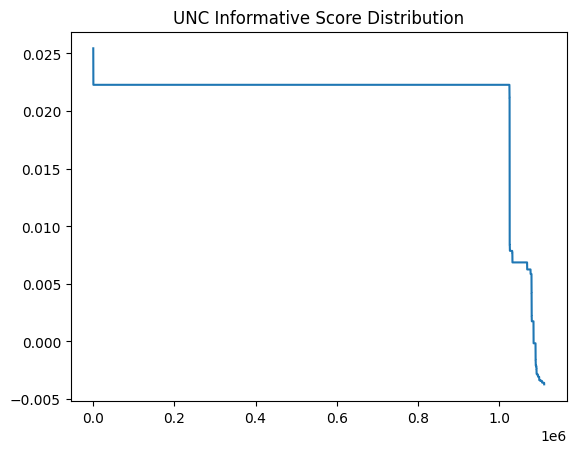

In [ ]:
informative_arr = np.array(query_lal_result[4][:])
informative_arr = -np.sort(-informative_arr)

plt.plot(np.arange(len(informative_arr)), informative_arr)
plt.title("UNC Informative Score Distribution")

<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Performance')

Text(0.5, 1.0, 'Active Learning Results')

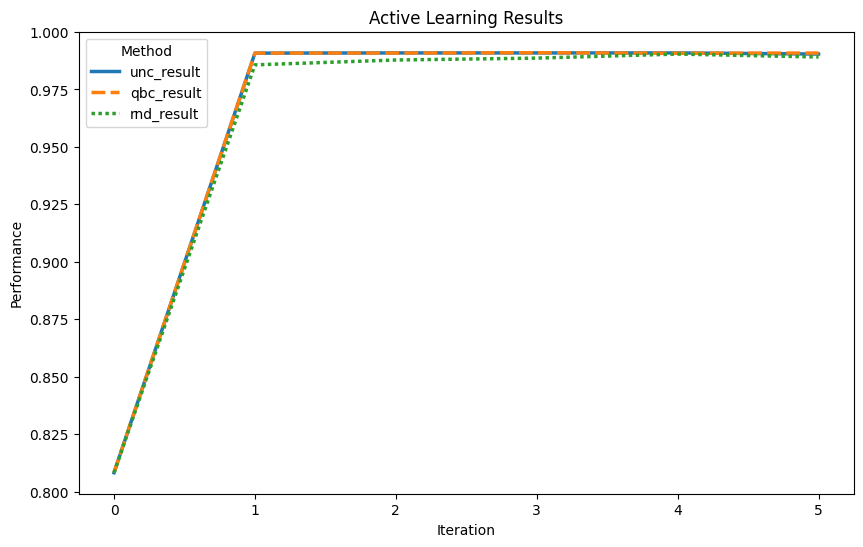

In [ ]:
# Plot the DataFrame
queried_data = pd.DataFrame({
    "unc_result": [41135, 6604, 6627, 673, 5943],
    "qbc_result": [35954, 20398, 4858, 4723, 7874],
    "rnd_result": [10778, 20778, 30778, 40778, 50778],
})
plt.figure(figsize=(10, 6))
sns.lineplot(data=new_result_df, palette='tab10', linewidth=2.5)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Performance')
plt.title('Active Learning Results')
plt.legend(title='Method', loc='best')

# Show the plot
plt.show()

# Real World Active Learning Simulation

In [ ]:
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']
anomaly_rate = 0.05
Xrw_train, Xrw_test, yrw_train, yrw_test, scaler = process_dataset(new_victim_df, anomaly_rate, train_perc=0.8)
Xrw_train.drop(columns=dropping_cols, axis=1, inplace=True)
Xrw_train_scaled = scaler.transform(Xrw_train)
Xrw_test_scaled = Xrw_test.drop(columns=dropping_cols, axis=1, inplace=False)
Xrw_test_scaled = scaler.transform(Xrw_test_scaled)
yrw_train = yrw_train.values
yrw_test = yrw_test.values

<function round(number, ndigits=None)>

### Scenario 1

In [ ]:
# Full
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix
np.random.seed = 4022

alibox = ToolBox(X=Xrw_train_scaled, y=yrw_train, query_type='AllLabels', saving_path=None)
alibox.split_AL(test_ratio=0.99, initial_label_rate=0.001, split_count=10)
round = 10
metric = f1_score
_, _, initial_label_ind, _ = alibox.get_split(0)
round = 10
metrics_dict = {
    'metric': {ip : {query : 0 for query in range(round)} for ip in new_victim_IP}
}      

unc = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty")
# qbc = alibox.get_query_strategy(strategy_name="QueryInstanceQBC")
# rnd = alibox.get_query_strategy(strategy_name="QueryInstanceRandom")
# lal = alibox.get_query_strategy(strategy_name="QueryInstanceLAL", cls_est=100, train_slt=False)
# lal.download_data()
# lal.train_selector_from_file(reg_est=500, reg_depth=25)    

lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)

lm_clf.fit(Xrw_train_scaled[initial_label_ind,:], yrw_train[initial_label_ind])

initial_acc = metric(lm_clf.predict(Xrw_test_scaled), yrw_test)

informative_score_list = []
unc_queries_accuracy = [initial_acc]
# qbc_queries_accuracy = [initial_acc]
# rnd_queries_accuracy = [initial_acc]
# lal_queries_accuracy = [initial_acc]

unc_label_size = [np.shape(initial_label_ind)[0]]
# qbc_label_size = [np.shape(initial_label_ind)[0]]
# rnd_label_size = [np.shape(initial_label_ind)[0]]
# lal_label_size = [np.shape(initial_label_ind)]

unc_label_ind = qbc_label_ind = rnd_label_ind = lal_label_ind = initial_label_ind
for i in range(round):
  unc_informative_score, unc_query_accuracy, unc_label_ind, model = batch_train(Xrw_train_scaled, yrw_train, 
                                                                    unc, i, Xrw_test_scaled, yrw_test, 
                                                                    unc_label_ind, lm_clf, metric, threshold=0.2)
  informative_score_list.append(unc_informative_score)
  unc_queries_accuracy.append(unc_query_accuracy)
  unc_label_size.append(np.shape(unc_label_ind)[0])
  metrics_dict = evalute_all_dvc(new_victim_IP, Xrw_test, y_test, model,scaler, metric, curr_round, metrics_dict)
# for i in range(round):
#   qbc_informative_score, qbc_query_accuracy, qbc_label_ind = batch_train(Xrw_train_scaled, yrw_train, 
#                                                       qbc, i, Xrw_test_scaled, yrw_test, 
#                                                       qbc_label_ind, lm_clf, metric, threshold=0.2)
#   qbc_queries_accuracy.append(qbc_query_accuracy)
#   qbc_label_size.append(np.shape(qbc_label_ind)[0])
# for i in range(round):
#   rnd_informative_score, rnd_query_accuracy, rnd_label_ind = batch_train(Xrw_train_scaled, yrw_train, 
#                                                       rnd, i, Xrw_test_scaled, yrw_test, 
#                                                       rnd_label_ind, lm_clf, metric, threshold=None)
#   rnd_queries_accuracy.append(rnd_query_accuracy)
#   rnd_label_size.append(np.shape(rnd_label_ind)[0])
  
# for i in range(round):
#   lal_informative_score, lal_query_accuracy, lal_label_ind = batch_train(Xrw_train_scaled, yrw_train, 
#                                                       lal, i, Xrw_test_scaled, yrw_test, 
#                                                       lal_label_ind, lm_clf, metric, threshold=0.0050)      
#   lal_queries_accuracy.append(lal_query_accuracy)
#   lal_label_size.append(np.shape(lal_label_ind)[0])

# ！！！ TODO Use Other Algorithms


([array([ 18887,  25846, 106213, ...,  22528, 170265,   3114]),
  array([ 81907,  69745, 116219, ..., 139020,  76520,  99517]),
  array([105855, 101373,  78952, ..., 160250,  71087,  84128]),
  array([177132, 105381,  41591, ..., 178295, 123642, 131560]),
  array([107875,  26516, 175570, ..., 100436,  13410,  12752]),
  array([176804,  44533,  62905, ...,   5534, 158396, 144552]),
  array([  6382, 143726, 149848, ...,  25843, 154927, 138206]),
  array([ 12420, 143645,  95512, ..., 154078, 116080,  55223]),
  array([ 74937,  57961, 144845, ..., 143768, 117557, 159426]),
  array([142961,   1116,  37481, ..., 135422,  95053, 123656])],
 [array([ 97907, 130090, 141286, ...,   4854, 105272, 160859]),
  array([ 56632,  37395, 105381, ..., 146895,  85330,  69731]),
  array([141281, 144545,  28425, ..., 123476,  21453, 109057]),
  array([ 92223, 167864,  60079, ...,  24622,  34735,  42629]),
  array([109599,   5120, 149792, ...,  45765,  15125,  21114]),
  array([ 62197, 150338, 161261, ..., 1

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 10000 Shape of Label_ind: (10002,)


NameError: name 'curr_round' is not defined

In [83]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix
np.random.seed = 4022
alibox = ToolBox(X=Xrw_train_scaled, y=yrw_train, query_type='AllLabels', saving_path=None)
alibox.split_AL(test_ratio=0.99, initial_label_rate=0.001, split_count=10)
# Define ToolBox for New Attacks

metric = f1_score
_, xx, initial_label_ind, _ = alibox.get_split(0)
strategy_name = "QueryInstanceQBC"
strategy = alibox.get_query_strategy(strategy_name=strategy_name)
# qbc = alibox.get_query_strategy(strategy_name="QueryInstanceQBC")



lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)

lm_clf.fit(Xrw_train_scaled[initial_label_ind,:], yrw_train[initial_label_ind])

initial_acc = metric(lm_clf.predict(Xrw_test_scaled), yrw_test)

informative_score_list = []
unc_queries_accuracy = [initial_acc]

unc_label_size = [np.shape(initial_label_ind)[0]]

unc_label_ind = qbc_label_ind = rnd_label_ind = lal_label_ind = initial_label_ind
for i in range(round):
  unc_informative_score, unc_query_accuracy, unc_label_ind, model = batch_train(Xrw_train_scaled, yrw_train, 
                                                                    strategy, alibox, i, Xrw_test_scaled, yrw_test, 
                                                                    unc_label_ind, lm_clf, metric, threshold=0.1, batch_size = 10000)
  informative_score_list.append(unc_informative_score)
  unc_queries_accuracy.append(unc_query_accuracy)
  unc_label_size.append(np.shape(unc_label_ind)[0])
  metrics_dict = evalute_all_dvc(new_victim_IP, Xrw_test, y_test, model, scaler, metric, i, metrics_dict)




([array([  8716,  66299, 135026, ..., 126157,  90515, 149782]),
  array([127769,  64216,  32914, ...,   1031, 181100, 130435]),
  array([139573,  17495, 157435, ...,   4656,  35433, 106728]),
  array([106253,  63909, 147558, ...,  22669, 174564, 119908]),
  array([ 51232,  30760, 176316, ...,  16535, 127032,  57654]),
  array([ 45107, 146980, 170941, ..., 174482, 127167,  30307]),
  array([164025,  61783,  39995, ..., 167496, 110840,  38077]),
  array([ 48136, 140623, 144182, ...,  61135,  89815,    293]),
  array([116123,  61939,  20914, ..., 115178,  50858, 148373]),
  array([ 77973,  54301, 140670, ...,  35388,  45731, 126591])],
 [array([ 49015, 107967,  86966, ...,   6124,  25334,   3793]),
  array([122550,   5012, 152570, ..., 117939, 174990,  92324]),
  array([ 57480,  40902,  32952, ..., 157279, 156754,  30757]),
  array([ 53402, 152400, 174578, ...,  69808,  69590,  95044]),
  array([118715,  52491,  28316, ..., 114894,  98205,  10496]),
  array([175614, 133883, 153557, ...,  

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

10000
Added 10000 Shape of Label_ind: (10002,)
1804
Added 1804 Shape of Label_ind: (11806,)
654
Added 654 Shape of Label_ind: (12460,)
528
Added 528 Shape of Label_ind: (12988,)
1005
Added 1005 Shape of Label_ind: (13993,)
960
Added 960 Shape of Label_ind: (14953,)
1091
Added 1091 Shape of Label_ind: (16044,)
1354
Added 1354 Shape of Label_ind: (17398,)
1013
Added 1013 Shape of Label_ind: (18411,)
1001
Added 1001 Shape of Label_ind: (19412,)


In [84]:
X_known = Xrw_train_scaled[label_ind]
y_known = yrw_train[label_ind]
X_new_scaled_train, X_new_scaled_test, y_new_train, y_new_test = train_test_split(X_new_scaled, Y_new, shuffle=True, test_size=0.2,
                                                                                  stratify=Y_new, random_state=4022)
X = np.concatenate([X_known, X_new_scaled_train])
y = np.concatenate([y_known, y_new_train])
new_label_ind = np.arange(len(X_known))
new_unlab_ind = np.arange(len(X_known), len(X))
divided_arrays = np.array_split(new_unlab_ind, 10)

alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None,)
alibox_new.split_AL(test_ratio=0.1, initial_label_rate=0.1, split_count=50)
new_strategy = alibox_new.get_query_strategy(strategy_name=strategy_name)
label_size = [len(new_label_ind)]
for i in range(10):
  informative_score, query_accuracy, label_ind, model = evaluate_new_atk(X, y, new_strategy, alibox_new, i, X_new_scaled_test, 
                                                                                    y_new_test, new_label_ind, divided_arrays[i], 
                                                                                    model, metric, threshold = 0.1)
  new_label_ind = label_ind
  print(query_accuracy)
# informative_score_list.append(unc_informative_score)
# unc_queries_accuracy.append(unc_query_accuracy)
  label_size.append(np.shape(new_label_ind)[0])

([array([70637, 76673, 59701, ..., 38225, 42702, 98857]),
  array([78229, 98591,    74, ..., 10899, 94757, 23641]),
  array([ 66619, 100135,  31443, ...,  61477,  77638,  44009]),
  array([ 7751, 59797, 61855, ..., 65095, 74180, 52740]),
  array([76490, 16210, 57317, ..., 22994, 70972, 39057]),
  array([74649, 42790, 61426, ..., 33430, 41512, 32101]),
  array([58052, 17586, 64390, ..., 54647, 38314, 58071]),
  array([94245, 42568, 50216, ..., 69013, 58382, 98133]),
  array([65304, 11665, 64890, ..., 12546, 52612, 33466]),
  array([ 29479,   1588,  50289, ..., 100632,  78317,  70664]),
  array([34056, 82454, 52780, ..., 14236, 58963, 78917]),
  array([95300, 55560,  1110, ..., 10526, 46403, 38034]),
  array([14598, 35135, 59935, ..., 24005,  7455,  4289]),
  array([72743, 66140, 33700, ...,  4467, 23774, 39145]),
  array([100487,  29872,  57319, ...,  85169,  41602,  92675]),
  array([ 85463,  71685,  27009, ..., 100091,  60956,  59781]),
  array([14581, 22882,  3544, ..., 34303, 45759,

1648
Added 1648 Shape of Label_ind: (46066,)
0.7466499910666428
1523
Added 1523 Shape of Label_ind: (47589,)
0.8714239794278367
2179
Added 2179 Shape of Label_ind: (49768,)
0.8714239794278367
1893
Added 1893 Shape of Label_ind: (51661,)
0.8714239794278367
1719
Added 1719 Shape of Label_ind: (53380,)
0.7466499910666428
808
Added 808 Shape of Label_ind: (54188,)
0.7466499910666428
1903
Added 1903 Shape of Label_ind: (56091,)
0.7466499910666428
1948
Added 1948 Shape of Label_ind: (58039,)
0.7466499910666428
1656
Added 1656 Shape of Label_ind: (59695,)
0.7466499910666428
1366
Added 1366 Shape of Label_ind: (61061,)
0.8714239794278367


Text(0.5, 1.0, 'Label Size Per Query')

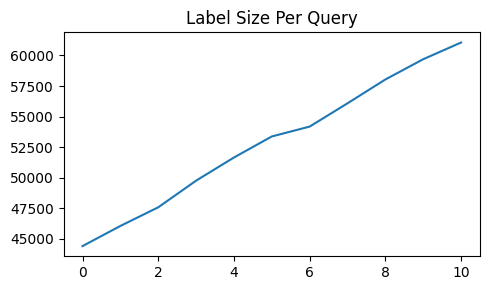

In [90]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(np.arange(len(label_size)), label_size)
ax.set_title("Label Size Per Query")
plt.tight_layout()
plt.show()

NameError: name 'result_df' is not defined

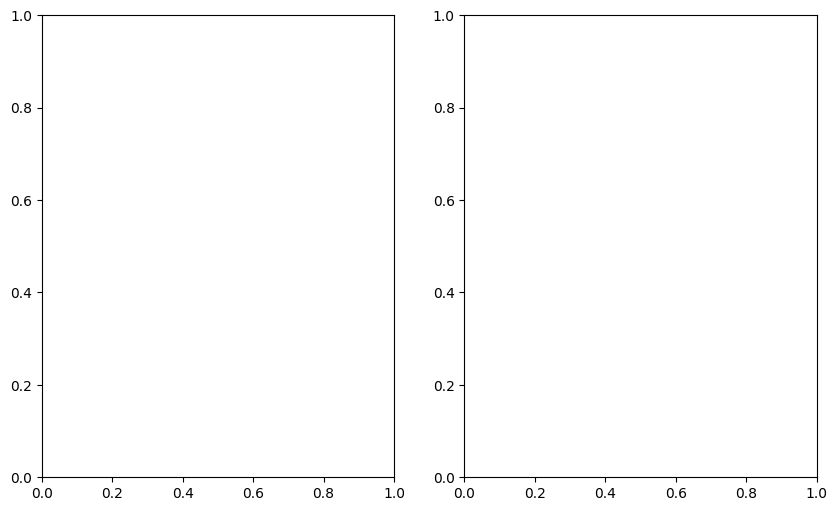

In [85]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.lineplot(data=result_df,ax=ax[0], palette='tab10', linewidth=2.5)

ax[0].set_title('Result DataFrame')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Performance')
ax[0].legend(title='Method', loc='best')

sns.lineplot(data=size_df, ax=ax[1], palette='tab10', linewidth=2.5)
ax[1].set_title('New Result DataFrame')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Performance')
ax[1].legend(title='Method', loc='best')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

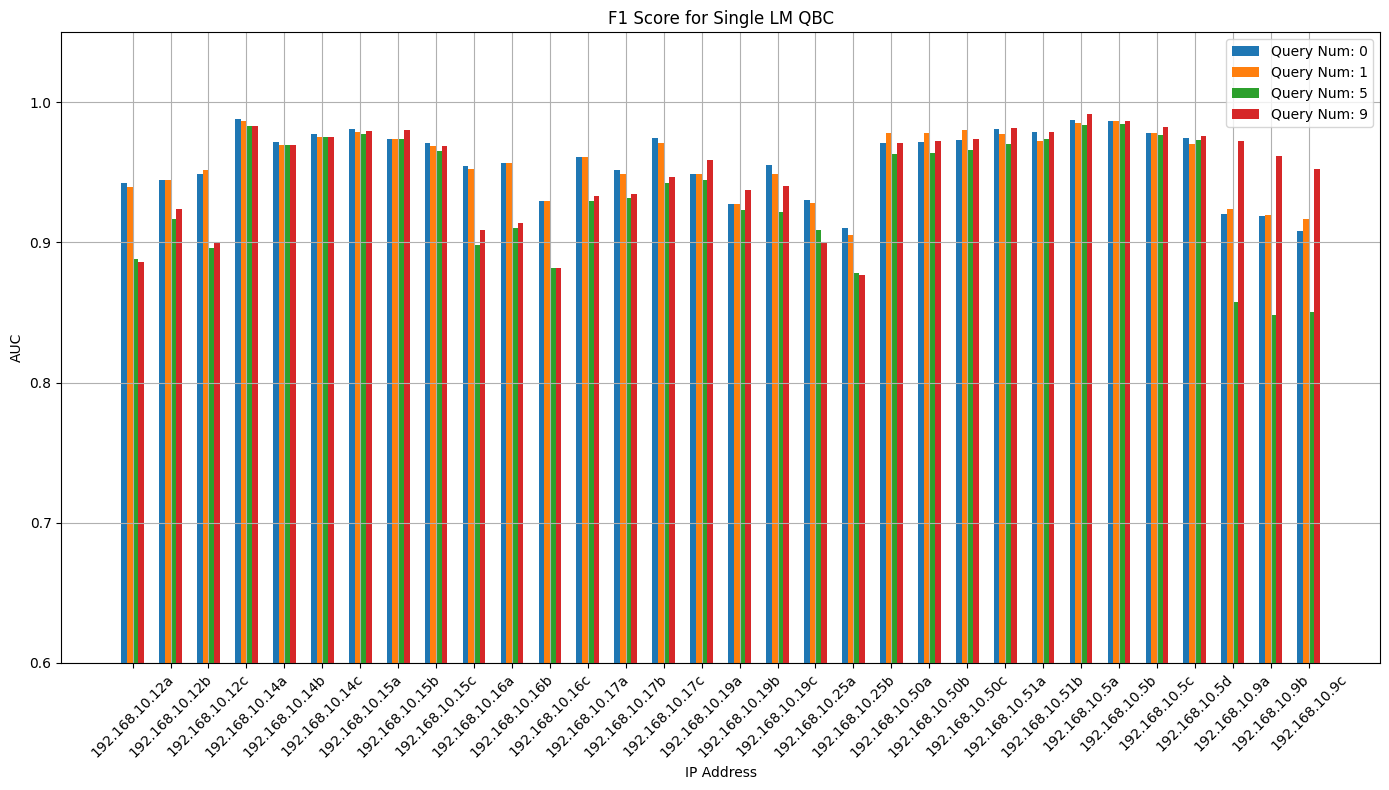

0.9499910831968862

In [91]:
plot_graph_scenario(metrics_dict, queries_iter = [0,1,5,9], title="F1 Score for Single LM QBC")
metric_values = []

for ip in metrics_dict['metric']:
    metric_values.append(metrics_dict['metric'][ip][9])

average_metric = np.mean(metric_values)
average_metric

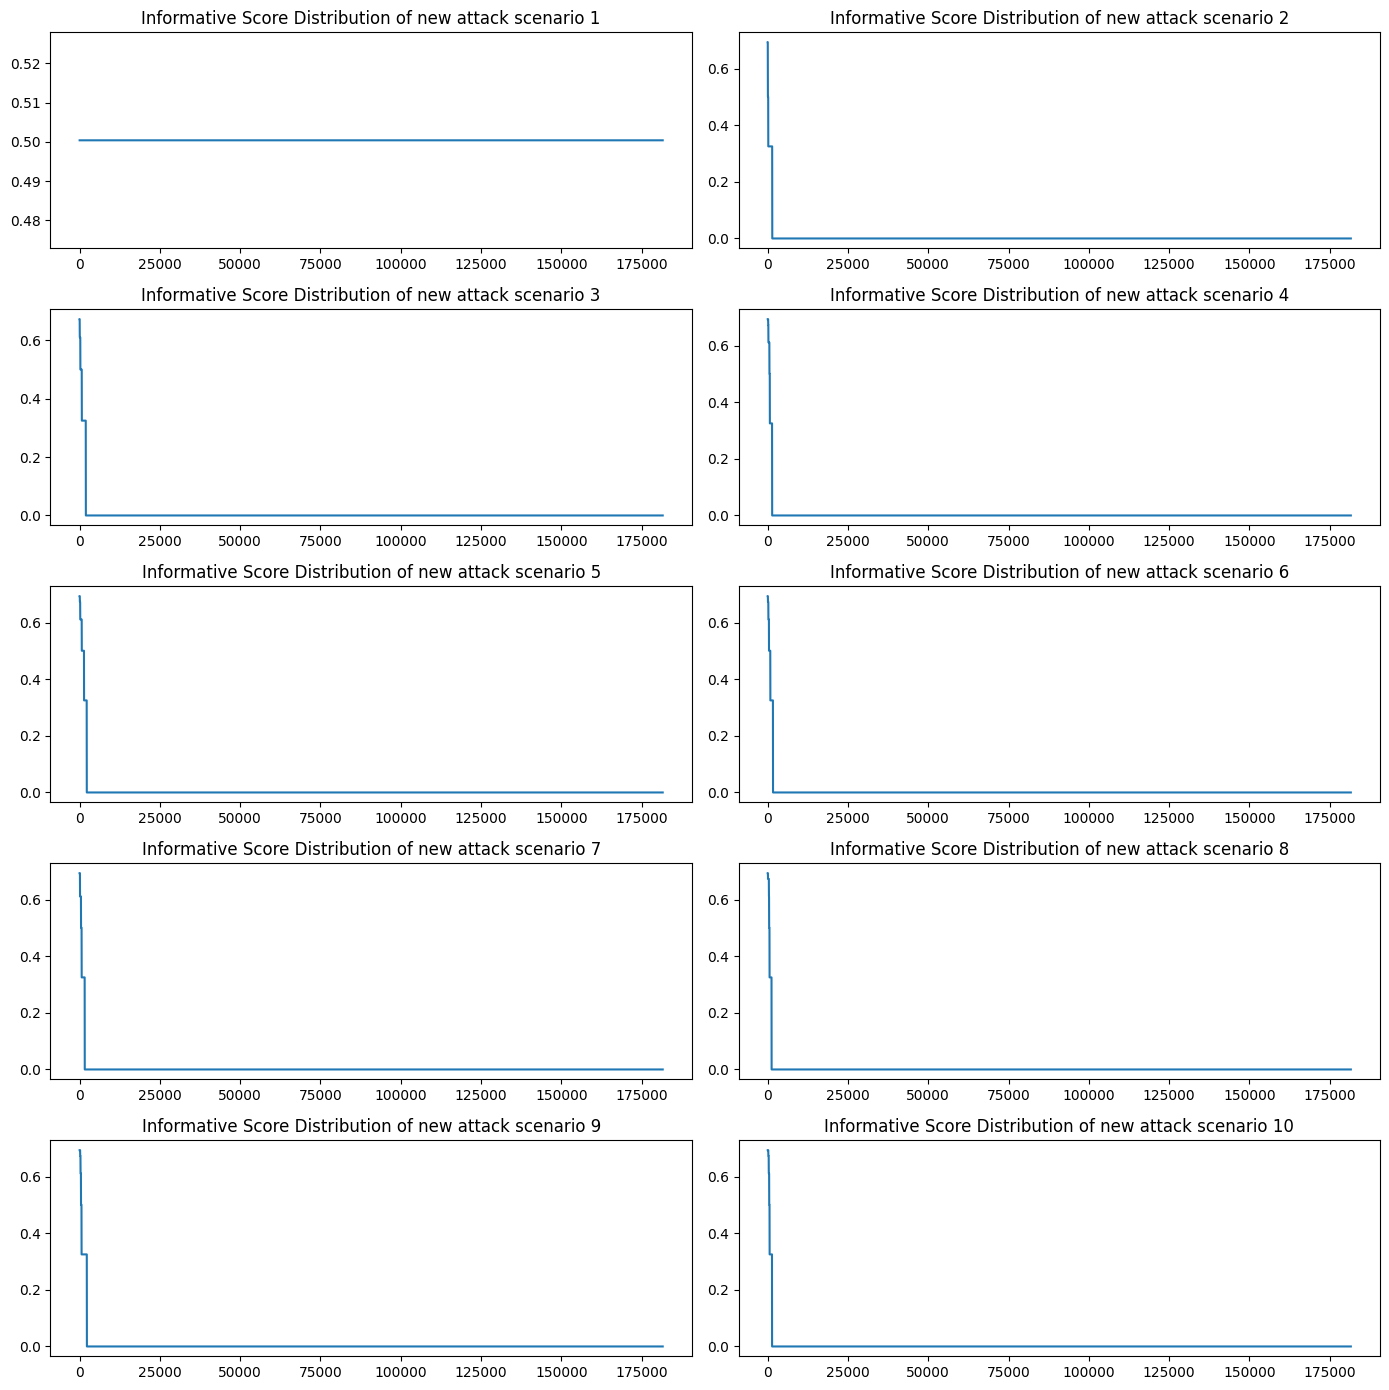

In [ ]:
plot_supporting_scores(informative_score_list, n_times=10)

Text(0.5, 1.0, 'Label Size Per Query')

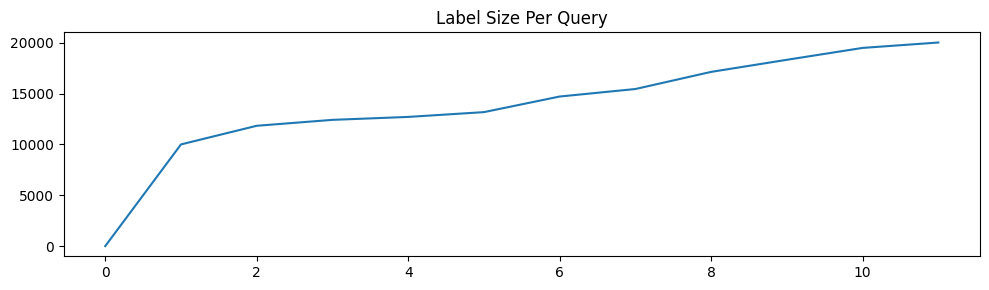

In [ ]:
informative_arr = np.array(informative_score_list[0])
informative_arr = -np.sort(-informative_arr)
fig, ax = plt.subplots(1,1, figsize=(10,3))


ax.plot(np.arange(len(unc_label_size)), unc_label_size)
ax.set_title("Label Size Per Query")
plt.tight_layout()
plt.show()


In [ ]:
unc_label_size

[2, 10002, 11406, 12652, 14677, 16590, 18506, 20568, 20821, 21076, 21514]

### Scenario 2

In [58]:
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']
anomaly_rate = 0.05
Xrw_train, Xrw_test, yrw_train, yrw_test, scaler = process_dataset(new_victim_df, anomaly_rate, train_perc=0.8)

Xrw_train.drop(columns=dropping_cols, axis=1, inplace=True)
Xrw_train_scaled = scaler.transform(Xrw_train)
Xrw_test_scaled = Xrw_test.drop(columns=dropping_cols, axis=1, inplace=False)
Xrw_test_scaled = scaler.transform(Xrw_test_scaled)
yrw_train = yrw_train.values
yrw_test = yrw_test.values
round = 10
metrics_dict = {
    'metric': {ip : {query : 0 for query in range(round)} for ip in new_victim_IP},
    'informative_score': {ip : {query : [] for query in range(round)} for ip in new_victim_IP},
    'size': {ip : {query : 0 for query in range(round)} for ip in new_victim_IP}
}      

In [68]:
for ip in new_victim_IP:
  # Get Current IP and Split into training testing
  # X_curr_ip = Xrw_train.loc[Xrw_train["Dvc Label"] == ip].copy()
  # X_curr_ip.drop(columns=dropping_cols, axis=1, inplace=True)
  # X_curr_ip_scaled = scaler.transform(X_curr_ip)  
  # X_curr_train, X_curr_test, y_curr_train, y_curr_test = train_test_split(X_curr_ip_scaled, Y_new, shuffle=True, test_size=0.2,
  #                                                                                 stratify=Y_new, random_state=4022)
  curr_ip_df = new_victim_df.loc[new_victim_df["Dvc Label"] == ip].copy()
  X_curr_train, X_curr_test, y_curr_train, y_curr_test, _ = process_dataset(curr_ip_df, anomaly_rate = 0.05, train_perc=0.8)
  X_curr_train_scaled, X_curr_test_scaled = X_curr_train.drop(columns=dropping_cols, axis=1, inplace=False), X_curr_test.drop(columns=dropping_cols, axis=1, inplace=False),
  X_curr_train_scaled, X_curr_test_scaled = scaler.transform(X_curr_train_scaled), scaler.transform(X_curr_test_scaled)
  y_curr_train, y_curr_test = y_curr_train.values, y_curr_test.values
  # Set Data Split for 10 batches
  alibox = ToolBox(X=X_curr_train_scaled, y=y_curr_train, query_type='AllLabels', saving_path=None)
  alibox.split_AL(test_ratio=0.99, initial_label_rate=0.1, split_count=10)
  strategy_name = "QueryInstanceUncertainty"
  strategy = alibox.get_query_strategy(strategy_name=strategy_name)
  _, x, label_ind, _ = alibox.get_split(0)
  
  lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)
  metric = f1_score

  lm_clf.fit(X_curr_train_scaled[label_ind,:], y_curr_train[label_ind])
  initial_acc = metric(lm_clf.predict(X_curr_test_scaled), y_curr_test)
  informative_score_list = []
  queries_accuracy = [initial_acc]
  label_size = [np.shape(label_ind)[0]]  
  for i in range(10):
    informative_score, query_accuracy, label_ind, model    = batch_train(X_curr_train_scaled, y_curr_train, 
                                  strategy, alibox, i, X_curr_test_scaled, y_curr_test, label_ind, lm_clf, metric, threshold = 0.1, batch_size = 600 )
    metrics_dict['metric'][ip][i] = query_accuracy
    metrics_dict['size'][ip][i] = len(label_ind)
    metrics_dict['informative_score'][ip][i] = informative_score

([array([4688, 2182, 3726, 4715,  864, 1763, 5533, 4808, 2156,  735, 1500,
          205, 1449,  732, 3766, 3397, 2863, 4229, 3807, 2698, 3904, 1864,
         1285, 3217, 2921, 3082, 5573, 1494, 4010, 3473,  787, 1305, 1379,
         3953, 2551, 3428,  682, 1300, 4934, 2213, 2970, 2758, 4342, 3636,
         2375, 2326,  724,   35, 2797, 3818, 1080, 4942, 1979, 5159, 2646,
         4528, 2482]),
  array([2285, 5593, 3892, 1056, 2294, 3858, 2257, 1910, 3149, 2564, 3714,
         1671, 4871, 5344,  484, 4518, 4992,  282, 3731, 2454,  401, 3642,
         2270, 4298,  632, 1470, 1182, 1604, 4976,  656, 5379, 4381, 5604,
         2591, 5050, 1660, 1395, 1561, 3235, 1819,  236,   71, 1571, 3074,
         4624,  731,  961,  910, 1566, 2468, 2235,  200, 5339, 5623, 3439,
         2252, 1504]),
  array([ 778,  505,  614, 2511, 4925, 4560, 5382, 4021, 2651, 5351, 1280,
         1854, 4388, 5314, 3958, 2613,  859, 4042, 5059, 5332, 3390, 3746,
           15, 4044, 4508, 2171, 2177,  508,  755, 219

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
200
Added 200 Shape of Label_ind: (806,)
221
Added 221 Shape of Label_ind: (1027,)
64
Added 64 Shape of Label_ind: (1091,)
64
Added 64 Shape of Label_ind: (1155,)
62
Added 62 Shape of Label_ind: (1217,)
64
Added 64 Shape of Label_ind: (1281,)
63
Added 63 Shape of Label_ind: (1344,)
63
Added 63 Shape of Label_ind: (1407,)
64
Added 64 Shape of Label_ind: (1471,)


([array([3737, 3893,  694,  516,   45,  311,  635, 2800,  480, 3976,  413,
         1036,  868,  666, 4195, 3065, 4077, 4256, 4421, 2170, 4500, 4430,
         4711, 2380,  503, 3701, 4719, 4856, 3430, 2513, 4265, 2904,   32,
         3370, 4523,  484, 2777, 4728, 4131, 2173, 5020, 1163, 1276, 4202,
           43,  154, 2286, 4432, 4795,  359,  780]),
  array([4868, 2713,  477, 2972, 2117, 2353, 3947,  248, 4480, 2956, 3110,
         2647, 2018,  755, 2460, 3116, 1517, 2341, 2040, 3978, 4875, 1645,
         1259, 4995,  935, 4429, 2069, 1048, 4258, 2612, 1191, 1919, 3269,
          856, 3761, 4568,  521, 1062, 3979,   89, 4567, 4866, 1271,  145,
         3365,  224, 4286, 2236, 1161, 4716,  163]),
  array([2658,  637, 3274,  665, 3521, 5063, 2471,  151, 4106, 3300,  828,
          834, 2199, 1411,  774, 4000, 1562, 1582, 4486, 1726, 1284, 3657,
         2026,  220, 1586, 1486, 3413,  180, 1756, 1454, 4703, 2058, 2977,
         4544, 3036, 2332, 1055, 3032, 1204, 2625, 4655, 2114, 2010, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (605,)
138
Added 138 Shape of Label_ind: (743,)
135
Added 135 Shape of Label_ind: (878,)
138
Added 138 Shape of Label_ind: (1016,)
137
Added 137 Shape of Label_ind: (1153,)
138
Added 138 Shape of Label_ind: (1291,)
138
Added 138 Shape of Label_ind: (1429,)
123
Added 123 Shape of Label_ind: (1552,)
32
Added 32 Shape of Label_ind: (1584,)
32
Added 32 Shape of Label_ind: (1616,)


([array([4138, 3133, 3791, 2576, 2915,  718, 2237, 4098, 3282, 1842, 2009,
          702, 1376, 4895,  915, 4167, 4569,  299,  549, 4145, 2708, 2565,
         3927, 1908,  977, 3987, 1960, 1596, 1034, 1377, 1059, 4402,  560,
         3953, 3915, 1247,  562, 2067, 2511, 2902, 2212, 2322, 4344,  181,
         2763, 3620,  934, 3558,  307, 2082]),
  array([3723, 1707, 3165, 4246, 4755, 4125,   87, 1769,  783,   99, 3597,
         3431, 4789, 1971, 4122,  809, 3575,   81, 2731, 2588, 4716, 3400,
         3662, 4786, 3102, 3269, 2651,  539, 1271, 4865, 4127, 1528, 3337,
         3387, 3014, 2188, 1676, 3392,  446,  377, 1616, 3403, 3083, 2251,
         1077,  287, 1308, 3604, 2514,   29]),
  array([3551, 2924, 2892, 4878, 3530, 1643, 1712, 1053, 4149,  438,   70,
         1945, 4034,  283, 1687, 1470, 3091,  844, 1147, 4970, 2352, 2726,
         3941, 3247, 2043,  641, 1302,  103, 4491, 3504, 1107, 2162, 2707,
         2936, 3445, 2275, 4956, 2013,  533, 1204,  233, 2299,  560, 4120,
      

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (605,)
124
Added 124 Shape of Label_ind: (729,)
49
Added 49 Shape of Label_ind: (778,)
90
Added 90 Shape of Label_ind: (868,)
119
Added 119 Shape of Label_ind: (987,)
119
Added 119 Shape of Label_ind: (1106,)
112
Added 112 Shape of Label_ind: (1218,)
82
Added 82 Shape of Label_ind: (1300,)
0
Added 0 Shape of Label_ind: (1300,)
0
Added 0 Shape of Label_ind: (1300,)


([array([4778, 7296,    1, 7285, 7115, 1852, 7458, 3990, 5838, 2951, 2751,
         2682, 7255,  744, 2296, 5091, 7207,  733, 3202, 1537, 5864, 4677,
         4809, 6403, 1825, 4715, 1629, 5896,  488, 1471, 1559, 6438, 6786,
         2887,  750, 1547, 5698, 1161, 5983, 1428, 5328, 1218, 6062, 3562,
         1174, 5962, 5950, 5338, 2339, 1323, 2596, 1287, 4052, 2051, 5167,
         7516, 7098, 1606, 1156, 6280,  826, 1130, 2041, 2023, 2348, 3426,
         4519, 3561,  963, 7258, 3231, 6077, 6327, 3792, 1300]),
  array([4450, 4579, 1160, 4856, 4265, 7462, 3082, 4738, 7187,  723, 1450,
         1637, 3959, 7484, 5661, 6060, 5877, 2628, 3951, 3467, 4980, 1539,
         4655, 4176, 5071, 1491, 7211, 4919, 3469,  600, 5695, 1310,  246,
         2709, 7466,  444, 5747, 7358, 3064, 4012, 2406, 2116, 3845, 3051,
         2884, 3245, 4421, 3446, 6268, 7491, 3746, 2225, 3254,  234, 4497,
          874, 5166, 5004, 1326, 5356, 4193, 5380, 1361, 5621, 2641, 5588,
          279, 3592, 2858, 3286, 21

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (608,)
125
Added 125 Shape of Label_ind: (733,)
106
Added 106 Shape of Label_ind: (839,)
104
Added 104 Shape of Label_ind: (943,)
80
Added 80 Shape of Label_ind: (1023,)
64
Added 64 Shape of Label_ind: (1087,)
54
Added 54 Shape of Label_ind: (1141,)
53
Added 53 Shape of Label_ind: (1194,)
54
Added 54 Shape of Label_ind: (1248,)
52
Added 52 Shape of Label_ind: (1300,)


([array([2308, 3407, 3265, 5286,  570, 1987, 3817, 4777, 1533,  244, 1966,
         4298, 2792, 2390, 4956, 5333,  781, 1693, 1423, 3406, 1299, 3844,
          640, 2502, 4313, 3624, 3607, 3581, 4962,  163, 3941,  652,  573,
         4906, 4825, 1527, 1008, 5011, 4130, 2866, 4636, 5255, 4963, 1123,
          514, 4459,  113, 2663,  873, 2296, 1662, 2264, 1139,  583, 5316]),
  array([4638,   38, 5172, 4879, 1721, 1751, 2249, 3963, 3809,  299,  875,
         5356,  582, 2138, 5271, 2705, 2795, 1941, 5106,  180, 5332, 3533,
         3621, 2551, 2279, 5257, 2938, 4446, 3268, 3245, 4453,  108, 5407,
         1786,  302, 5457, 3643, 5306, 1603, 4406, 3570, 2884, 3234, 3893,
         1718,  535, 4510, 1201, 4069, 4591, 1650, 1973, 1608, 4940, 5112]),
  array([1375, 4610, 1032, 3423,  406, 5232, 4495, 3767, 2551, 1589, 2490,
         3220, 2264, 2182, 5261,  293, 4357, 1110, 5343, 2842, 1190, 1355,
         1241, 4466, 2795, 4994, 4146, 1365, 3095, 5230, 4396,  291, 5035,
         2988, 4127, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)


([array([5921, 4593,  338, 2683, 2530, 1268,  700,   22, 5337, 1743, 4683,
         2946, 1856, 4963, 4767, 3696, 1772, 2232, 5239, 2900, 2939,  115,
         4747, 3159, 4100, 2655, 2605, 2848,   99, 1288, 3520, 1821, 4306,
         4978,  898, 3449, 4301, 5612, 6495,  683, 4866, 6362, 5086, 3550,
         1979, 6267, 1454, 3029, 1836, 4266,  580, 2021, 5303,  347, 2314,
         4506, 2731,  384, 6131, 2472, 3393, 4184, 2118, 3754, 2600,  646,
         5438]),
  array([4212, 1351,  233, 5842, 1992, 5896,  157, 4735, 3538, 5314, 5609,
         5278,  558,  673, 5640,  298, 1006, 4576,  236, 3242, 6109, 1422,
          988, 5534,  290, 4707,   85, 2409,  634, 6040, 4402, 3678, 2878,
          552, 5987, 2062, 2456, 4310, 2743, 2277, 2883, 6378, 2090, 1812,
         3355, 5339,  847, 4992, 2483, 4827,  732, 1009, 6240, 2965,  224,
         2664, 6535,  770, 5496, 1696, 5521, 5977, 4555, 6219, 2186,  823,
         5254]),
  array([2068,  588, 1812, 4689, 5265,  177, 1458, 3564,  915, 531

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (607,)
0
Added 0 Shape of Label_ind: (607,)
0
Added 0 Shape of Label_ind: (607,)
0
Added 0 Shape of Label_ind: (607,)
0
Added 0 Shape of Label_ind: (607,)
0
Added 0 Shape of Label_ind: (607,)
0
Added 0 Shape of Label_ind: (607,)
0
Added 0 Shape of Label_ind: (607,)
0
Added 0 Shape of Label_ind: (607,)
0
Added 0 Shape of Label_ind: (607,)


([array([1921, 2546, 1688, 5323, 5365, 5263, 5571, 5168, 2257,  801, 7065,
         5493, 1955, 1316, 3278, 5883, 3989, 5717, 4200, 3126,  514, 5086,
         5371, 2124,  652, 2623, 4335, 6339, 4923, 5681, 6166, 1152, 1631,
         5662, 3772, 1990,  333, 5734, 4314, 1046, 1718, 1031,  467,  230,
         3153, 3523, 3944, 3003, 5350, 5952, 5213, 2795, 1998, 4401, 1967,
         4058, 3675, 5714, 1423,  643, 6472, 5629, 7072, 7052, 5776,  120,
         6589,  530, 4888, 5119, 6315, 5087, 4877]),
  array([4800, 6627, 3116, 2337, 1686, 6233, 5345, 2643, 2283, 5892, 1442,
         4487, 4847, 4665, 2037, 6183, 4277, 5808, 5483, 6730, 3592, 2473,
         2570, 5211,  399, 4358, 6716, 2784, 3009, 2104, 5261, 4506, 5910,
         1763, 7038, 5070, 4790, 4294, 5448, 3966, 4379, 2186, 3541, 1046,
          392,  545, 4803, 6091,  648, 1422, 3192, 3169,  630, 2812, 3120,
         4845, 5563, 5222, 1933, 6330, 1583, 3055, 2608, 5120, 1181, 3780,
         6139, 3016, 6110,  353, 2178, 2496, 36

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (607,)
193
Added 193 Shape of Label_ind: (800,)
77
Added 77 Shape of Label_ind: (877,)
76
Added 76 Shape of Label_ind: (953,)
74
Added 74 Shape of Label_ind: (1027,)
32
Added 32 Shape of Label_ind: (1059,)
33
Added 33 Shape of Label_ind: (1092,)
32
Added 32 Shape of Label_ind: (1124,)
33
Added 33 Shape of Label_ind: (1157,)
33
Added 33 Shape of Label_ind: (1190,)


([array([ 657,  686, 3328, 1362, 4328, 2007, 3265, 1403, 3191,  640, 4723,
          986, 3317,  528,  805, 4583,  940, 3696, 5615, 1162,  794, 3453,
         1327, 4333, 2275, 2492,  670, 5449, 1078, 5586, 4825, 4726, 5200,
         3081, 4464, 3310, 2018, 4398, 5624, 4505, 2474, 1090, 2186, 5483,
         3225, 3085, 1453, 1498, 3517, 1566, 3307, 4857,  842, 1335, 2153,
         4413, 3069]),
  array([4871, 5296, 1299, 2895, 5467,  832,  140, 1525,  887, 3856, 3873,
         5601, 4953, 3887, 1401, 1823, 3809, 3662, 5115,  149, 2910, 3904,
         5037, 4741, 1575, 2452, 5484, 4124, 5249, 5547, 5329, 1622, 2112,
         5251, 2072, 3877, 4738, 3016, 2814, 1256, 4805, 5554, 3432, 1935,
         5532, 1685, 3007, 1012, 2675, 2868, 4185, 4011, 1798, 1250, 4867,
          695, 4389]),
  array([ 494,  406, 3304, 4757, 4224,  385, 3503, 1887, 1905, 4181, 5070,
         2342, 5587, 2980, 3163, 2666, 4617, 3420, 1364, 4737, 2579, 4218,
          718,  427, 4909, 4433, 1697,  436, 1333, 297

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)
0
Added 0 Shape of Label_ind: (606,)


([array([5570, 5435,  665, 3411, 5527, 1217, 4487, 7149, 6591, 1195, 7031,
         5000, 2193, 3158, 6186, 2639, 4292, 6505, 5903, 5735, 1873, 7273,
         3429, 7465, 2353, 5373, 5494, 6758, 2674, 6420, 5979, 5522, 4596,
          139, 4063, 5664, 6615,  837, 2622, 7345, 3535, 4270, 5620, 4401,
         3788, 7342, 5969, 3394, 3885, 4482, 3057, 1305, 6118, 2719, 4227,
         5962, 4008,  384, 7035, 3935, 3811, 5063, 4958,  270, 3800, 7038,
         6711, 4745, 7552, 3723, 2803, 1971, 7196, 2554, 4460, 4799]),
  array([2072, 1042, 4594, 4027, 5894, 5949, 5363, 3573, 5567, 5034, 6809,
          396, 1139, 5920,  689, 3078, 2222, 5241, 2462, 2126, 1291, 2985,
         4205, 2571, 2119, 6918, 6406, 7231, 2275,  771, 5409, 5619, 6088,
          188, 1637, 5645, 5672, 5341, 3718, 1890, 6034, 6914, 2157, 7415,
         3164, 1262, 6284, 7245, 4417, 4222, 6708, 4667, 4672, 1497,  599,
         3936, 3861, 1072, 3470, 7482,  745,  347, 5425, 2208,  583, 5108,
         4765, 3887, 3404, 21

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (608,)
137
Added 137 Shape of Label_ind: (745,)
113
Added 113 Shape of Label_ind: (858,)
111
Added 111 Shape of Label_ind: (969,)
66
Added 66 Shape of Label_ind: (1035,)
67
Added 67 Shape of Label_ind: (1102,)
55
Added 55 Shape of Label_ind: (1157,)
54
Added 54 Shape of Label_ind: (1211,)
53
Added 53 Shape of Label_ind: (1264,)
52
Added 52 Shape of Label_ind: (1316,)


([array([5107, 1103, 2631,  975, 4120,  289, 5772, 4545,  102, 4325, 5594,
          276, 4031, 3242, 2435, 4091,  832, 4447, 1042, 2471, 4136, 3305,
         3825, 4795, 1933, 1043,  217, 4205,  858, 2629, 4298,  432,  996,
         4360, 5797, 2214, 3362, 3227,  877, 2062, 3423, 4508, 5757,  871,
         2752, 3621, 3090, 5917, 2849, 5695, 3358, 2265, 1055, 2123, 3714,
         2870,  494, 1508, 3037,  819]),
  array([ 856, 5037, 4954, 5618, 1403, 2059, 4803, 1186, 4798,  604, 2834,
         1713, 3677,  963, 1032, 3858, 2541, 3691,  891, 5325, 1561, 2051,
         4102, 5353,  559, 2421, 1288, 4822, 2950, 3466, 3291, 5609, 5522,
           38,  727, 2578, 1724, 1480, 1433, 1061, 5287, 5066, 1328, 4688,
         1067,   16, 1119, 4917, 5319,   95, 5411, 1327,  872,   19, 2165,
         5625,  832, 5422, 5067,  863]),
  array([4056, 2598,  158, 5511, 3740, 5701, 3025, 5706, 2658, 5698, 4580,
          499,  385, 3554,  535, 1343, 3308,  599, 1385, 3621, 2992, 2108,
         5520, 393

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
126
Added 126 Shape of Label_ind: (732,)
126
Added 126 Shape of Label_ind: (858,)
129
Added 129 Shape of Label_ind: (987,)
0
Added 0 Shape of Label_ind: (987,)
0
Added 0 Shape of Label_ind: (987,)
0
Added 0 Shape of Label_ind: (987,)
0
Added 0 Shape of Label_ind: (987,)
0
Added 0 Shape of Label_ind: (987,)
0
Added 0 Shape of Label_ind: (987,)


([array([4948,  108,  746, 1463, 2573, 2920, 1484, 5032, 2158, 4605, 2105,
         1110, 2517, 2423, 3090, 2274, 1750, 1791, 5216,  530, 1192, 4538,
         3592, 1803, 2224, 2284, 4836, 3116, 3476, 5257, 2588,  237,  329,
         3010,  555, 5584, 4307,  435, 4220, 4525,  497, 4433, 4541, 4465,
         1742, 1015, 4176, 4657, 4766, 2806, 3742,  622,  455, 3238, 5046,
         5267]),
  array([1996, 2406, 3053, 2052, 2805, 4452, 2032, 3390,  317, 3967, 5323,
         1569, 2791, 4635, 3218, 4756, 4113, 1880,  268, 5162, 4684, 2191,
         2715, 4152,   70, 1297, 4099, 3352, 5505,  531, 2305, 2756, 3753,
         5401, 4910, 4800, 1992, 5142, 1201, 2180, 4671, 2914, 1803, 1006,
         3438, 5121, 4786, 3104, 1662, 3471, 3329, 4244, 2969,  182, 5421,
         4057]),
  array([4831, 2036, 3687, 3456, 4568, 4992,  675, 2721, 2420,  474, 2965,
         5426,  579, 1636, 2854, 1035,  722,  144, 3565, 5067,  695, 4549,
         4641, 3156, 3778, 4615, 2120,  263, 2991,  870, 2864, 243

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
310
Added 310 Shape of Label_ind: (916,)
170
Added 170 Shape of Label_ind: (1086,)
171
Added 171 Shape of Label_ind: (1257,)
0
Added 0 Shape of Label_ind: (1257,)
0
Added 0 Shape of Label_ind: (1257,)
0
Added 0 Shape of Label_ind: (1257,)
0
Added 0 Shape of Label_ind: (1257,)
0
Added 0 Shape of Label_ind: (1257,)
0
Added 0 Shape of Label_ind: (1257,)


([array([2251, 1156, 1006, 3281, 3482, 2498, 2554,  634,  945, 2527, 1030,
         3891, 1702, 3500, 2773, 1475, 2019, 2506, 4087, 3263, 1342, 3362,
         1860, 1667, 2680,  918,  167, 3867, 2185, 2694,  437, 2193,  333,
          331, 3075, 3961, 1761, 1685, 3145, 3737,  987, 2685]),
  array([3057, 1767, 2727, 2920, 3045, 2633,   51, 2022, 3322, 1449, 3850,
         1947, 2725,  931,  395, 3248, 1462, 3192, 3563, 2619, 1949, 3187,
         3862, 3439, 1228,  559, 3379, 2852,  134, 2289,  315, 1607, 2205,
         2360, 1622,  971,  227, 3236, 2756, 2918, 3399, 2352]),
  array([1489,  831, 1772, 1571, 2896, 3481, 2658, 3495, 3354, 2025,  808,
          205, 2188,  560, 3594, 1400, 1697,   92, 3941,  961, 3643, 2877,
          893, 3803, 1496, 1414, 2198,  650, 3514, 3834, 3875, 2888, 3387,
          301, 2222, 1573, 3797, 2337, 1387, 2592, 1867, 2265]),
  array([1132, 2761, 1341, 3077, 3809, 3451, 1316, 2692, 3165,  376, 2705,
          898, 1812, 1656,  519, 3880, 3905, 1548, 1830

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (604,)
162
Added 162 Shape of Label_ind: (766,)
96
Added 96 Shape of Label_ind: (862,)
95
Added 95 Shape of Label_ind: (957,)
206
Added 206 Shape of Label_ind: (1163,)
94
Added 94 Shape of Label_ind: (1257,)
68
Added 68 Shape of Label_ind: (1325,)
68
Added 68 Shape of Label_ind: (1393,)
65
Added 65 Shape of Label_ind: (1458,)
67
Added 67 Shape of Label_ind: (1525,)


([array([2596, 3147, 4511, 4686, 1599, 1171, 1577, 4787,  731, 2389, 3175,
         4837, 3078, 2695, 2397,  872, 3926, 1671,  463, 3047,  423, 1462,
          485, 3701, 3852, 2665, 1160, 1162, 3214, 2124,  135, 4680, 4169,
          542, 2139, 2222, 2348, 3364,  456, 1397, 2549, 3508,  428, 1507,
         3703, 4463, 2194,  418, 4895]),
  array([3205, 3776, 2294, 1742, 4815, 4828, 1438, 4036,  490, 1741, 3476,
         3139, 4703, 3047, 2095,  879,  677, 4661, 2950, 1215, 3311, 3994,
         2838, 4729, 2348, 4011, 2772, 4579, 3246, 2435, 4535,  512, 4605,
         3134, 2592, 4607, 2725, 4311, 3581,  758, 2100,  573, 3513,  833,
         3286, 3223, 4093, 4785, 4159]),
  array([  24, 2009, 4621, 4441, 1045,  591, 1701,   33, 1442, 1821, 3419,
         4287, 2626, 1310, 3771, 4082, 2984, 1836, 2484,  972, 4197,  656,
         1562,  915, 1875, 3954, 4181, 2508, 2072, 4447, 2657, 4429,   87,
         4929, 1588, 3486, 2489, 1880, 1188,  923, 1630, 4722, 3945, 1498,
          784, 369

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (605,)
172
Added 172 Shape of Label_ind: (777,)
128
Added 128 Shape of Label_ind: (905,)
95
Added 95 Shape of Label_ind: (1000,)
81
Added 81 Shape of Label_ind: (1081,)
82
Added 82 Shape of Label_ind: (1163,)
82
Added 82 Shape of Label_ind: (1245,)
81
Added 81 Shape of Label_ind: (1326,)
51
Added 51 Shape of Label_ind: (1377,)
50
Added 50 Shape of Label_ind: (1427,)


([array([3461, 3551, 1161, 1475,  421, 5298, 1490, 1541, 3839, 2701, 1948,
         3557, 2775, 4824, 2636,  976, 2071, 5055, 3294, 1517, 1240,  628,
         5595, 4399, 1124, 4562, 3840, 5562, 2754, 4115, 5576, 2105, 4957,
          499, 1150, 1343,  300,  239,  273, 5316, 3149, 4935, 4423, 4725,
         4180, 2050, 2520, 5705, 5312, 1706, 4301, 3652, 1986, 1289, 2252,
         1731, 3263, 5175, 4972, 4527, 5274]),
  array([ 670, 1611,  703, 5873,  678,  734, 2886, 1735, 3538, 4025, 4752,
         3882, 5762,  855, 4597, 1613, 3813, 1048, 5961, 1855, 2790, 3041,
         1350, 2708, 5017, 5636, 4126, 2816, 1644, 2641, 2332, 4650,  988,
          738, 3279, 1686, 1662,  458, 5706, 1494, 1787,  934,  201, 1003,
         3223, 4595, 4529, 1222, 4544, 2794, 5772, 6011, 2125, 3530, 2937,
         3667,  223, 5774, 5467, 1698,  894]),
  array([5533, 5202, 5428, 2689, 3387, 2038, 1534, 1063, 5276, 4905, 3223,
         2029, 4615, 4376, 3662, 2611, 4079,  924, 5674, 2223, 4287, 3572,
      

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
135
Added 135 Shape of Label_ind: (741,)
123
Added 123 Shape of Label_ind: (864,)
121
Added 121 Shape of Label_ind: (985,)
155
Added 155 Shape of Label_ind: (1140,)
154
Added 154 Shape of Label_ind: (1294,)
154
Added 154 Shape of Label_ind: (1448,)
106
Added 106 Shape of Label_ind: (1554,)
106
Added 106 Shape of Label_ind: (1660,)
107
Added 107 Shape of Label_ind: (1767,)


([array([3066, 2886, 4112,  306, 3113, 1031, 1717,  179,  717, 3379, 2484,
         3477,  649, 2723, 3983, 3586, 1763, 1131, 1102, 3905, 3021,  449,
          703, 3437,  729, 2231, 3592,  192, 3314, 3029, 1790, 4156, 2394,
         2007, 3439, 2408, 2161, 4146, 3373, 2350, 1248, 3648, 2010]),
  array([ 660, 3983, 1103,  642, 3065,  543, 2823,  151, 2557, 1701, 2869,
         1348, 4084, 1442, 1277,  912, 1093,  404, 1698, 1904,  480, 2169,
          688,  670, 1860, 2249,  656,  718, 3855,  330, 2954, 1336,  797,
         2350, 2409, 1209, 1909, 1223, 1325, 1740, 2034, 1704, 2128]),
  array([1132, 3067,  460, 1701, 2675, 3605, 3856,  961,  326,  597, 3659,
         3828, 3762, 4247, 3582,  895, 2810, 2352,  911,   59,  564, 3391,
         1471, 2912, 3200, 3468, 4283,  827, 3104, 4244,  451, 1440,  386,
         2329,  814, 3118, 3290, 3526, 2447, 2079, 2413, 2046, 3192]),
  array([3835, 2938, 2600, 1828,  179, 4135, 3468, 2981, 2193, 3070, 1175,
         2786,  874,  961, 1538,  300

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (604,)
126
Added 126 Shape of Label_ind: (730,)
110
Added 110 Shape of Label_ind: (840,)
154
Added 154 Shape of Label_ind: (994,)
101
Added 101 Shape of Label_ind: (1095,)
147
Added 147 Shape of Label_ind: (1242,)
143
Added 143 Shape of Label_ind: (1385,)
40
Added 40 Shape of Label_ind: (1425,)
33
Added 33 Shape of Label_ind: (1458,)
33
Added 33 Shape of Label_ind: (1491,)


([array([2981, 4319, 2031,  385, 2097,  930,  260, 3347, 2092,  860, 3597,
          576, 1599, 3470,  164, 1023, 3742, 3727,   13,  986, 2691,  956,
         1068, 1630, 1047,   63, 1405, 1808, 3444, 3717, 3725, 4212,  673,
         2884, 3284,  206, 2376, 2465, 2345, 2767, 2454,  895, 1660, 2799]),
  array([3173, 1204, 3595, 1582, 3648, 2386, 2663, 1433, 3684,  792, 1584,
          550, 2604, 3634, 3457, 3849, 1921, 3958, 2465, 2158, 2546, 1039,
         2292, 2816, 3510, 2251, 1428,  652, 1311, 1512, 3412, 3034, 2742,
         3042, 4361, 3362, 3661, 1232, 3488,  768,  901, 3445, 1250, 1439]),
  array([3636, 3383, 1291, 3705, 1549, 3165, 2837, 1519,  760,  729, 2431,
         2373,  482, 3656, 2540,  954, 2094, 3428, 4270, 4188, 3035, 1289,
         3997, 2326, 1277,  810, 2468, 2253, 3235,  779, 3793,  281, 1852,
         1858, 4234,   32, 1529, 4367,  985,  712, 4047, 2039, 2256,  299]),
  array([1870, 2480, 3107, 1036, 3389, 2470, 3716, 1832, 1349, 2928, 2756,
         1312,  377

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (604,)
155
Added 155 Shape of Label_ind: (759,)
151
Added 151 Shape of Label_ind: (910,)
137
Added 137 Shape of Label_ind: (1047,)
101
Added 101 Shape of Label_ind: (1148,)
101
Added 101 Shape of Label_ind: (1249,)
82
Added 82 Shape of Label_ind: (1331,)
79
Added 79 Shape of Label_ind: (1410,)
99
Added 99 Shape of Label_ind: (1509,)
71
Added 71 Shape of Label_ind: (1580,)


([array([3706,  581,  418, 4594, 1463, 5263, 2574, 4673, 4333, 1138,  507,
         5085, 3219,  376, 5763, 1567,  278, 1854,  491, 5480, 4586, 2850,
         3849, 1987, 1208, 5331, 3066,  777, 1418, 4605,  245, 3385, 3057,
         2539, 2213, 5078, 3422, 1608,   71,  664, 2823, 4382, 4824, 3621,
         5143,  400, 1368, 4488,  711,   25, 4294, 3856,  896, 4135, 5165,
         2092, 5639, 3520,  801]),
  array([1461, 2608, 2498, 1449, 2449, 1747, 1699, 4674, 4043,  888, 3036,
         1479, 1085, 5106,  952, 2146, 1504, 4023,  420, 1194,  518,  411,
         3617, 4582, 3381, 2452, 5364, 1135,  502,  140, 4691, 2170, 1666,
         1009, 4252, 5273, 5583,  905, 2831, 1223, 3124, 4272, 4568, 2462,
         3078, 3112,  237, 1575, 2743, 4545, 1962, 1990, 5575, 2583, 4824,
         3164,  789, 5590, 4258]),
  array([4310,  213, 2225, 4327, 3289, 3461,  536, 4917, 3674, 1689, 2244,
         4394, 5010, 3495, 3485, 4339, 3881, 4070, 1515,  392, 3802, 2645,
         5805, 5658, 3774, 115

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
182
Added 182 Shape of Label_ind: (788,)
227
Added 227 Shape of Label_ind: (1015,)
147
Added 147 Shape of Label_ind: (1162,)
107
Added 107 Shape of Label_ind: (1269,)
109
Added 109 Shape of Label_ind: (1378,)
119
Added 119 Shape of Label_ind: (1497,)
119
Added 119 Shape of Label_ind: (1616,)
125
Added 125 Shape of Label_ind: (1741,)
110
Added 110 Shape of Label_ind: (1851,)


([array([4465, 3756, 2635,  609, 4194, 4274,  400, 3814, 4400,  412, 4913,
         2464,  757, 4570, 2334, 2449, 3005, 2606, 4064, 1271, 4360,  295,
         1435, 1224, 1206, 2329,  934, 2608, 2155,  694, 1737,  205, 2502,
         2392, 3398, 1890, 2380, 3991, 4186, 2254, 3829, 4133, 2037,  225,
         4757,  406,  206, 2483, 3556, 2412]),
  array([1709,  991,  148, 1483, 1897, 3215, 4711,  907,  135, 2097,  386,
         2797,  236, 3521, 1080, 4926, 3590,   33, 2151, 2302, 1527, 2288,
         3412, 2073, 3397, 4606, 4331,  424, 4245, 4381, 2455, 4767,  445,
         4388,   67, 2093, 2392, 1901, 3001, 4079, 1335, 2263, 4082, 3600,
         3664,  275, 1983, 4938, 4636, 2670]),
  array([4321, 4227, 4306, 4167, 2520, 1499, 1194,  907, 1866, 2239, 4922,
         3967, 2977, 1946, 3399,  968,   76,  156, 4171, 3277, 3457, 4758,
         2283, 4030, 4811, 2579,  577, 3990, 2790, 1074, 1651, 4083, 1022,
         4843, 3858, 1444, 1493,  438,  991,  887, 4546, 1550, 4615, 3445,
      

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (605,)
55
Added 55 Shape of Label_ind: (660,)
56
Added 56 Shape of Label_ind: (716,)
56
Added 56 Shape of Label_ind: (772,)
56
Added 56 Shape of Label_ind: (828,)
56
Added 56 Shape of Label_ind: (884,)
55
Added 55 Shape of Label_ind: (939,)
56
Added 56 Shape of Label_ind: (995,)
55
Added 55 Shape of Label_ind: (1050,)
56
Added 56 Shape of Label_ind: (1106,)


([array([ 800, 5121, 2767, 6316, 1930, 2803, 2270, 1973, 1633, 4790, 1578,
         1365, 5352, 4370, 3495, 3203, 4347, 4651,  447, 4712, 4778, 5152,
         7928, 4588,  950,   36, 6978,  182, 1969, 1880, 1981, 1526, 3820,
         4536, 8057, 5899, 1846, 4285, 4859, 5008, 5136, 5234, 3023, 5145,
         5351, 1313,  109, 5253, 2194,  336, 1453, 5785, 2768, 3007, 2610,
         8034, 1668,  413,  452, 6013, 1982,  533, 6796, 3743, 3723, 2096,
         1303, 5466, 1292, 1246, 4337, 4863, 2776, 1868, 7335, 1371, 6733,
         6638, 5728, 2652,  548, 3432]),
  array([6201, 2058, 7561, 2968, 4581, 1769, 7416,  500, 6833, 5506, 3029,
         7239, 4699, 3185, 1401, 5429, 6912, 5879, 4426, 5472, 7853, 6528,
          842, 5609, 5827,  953, 3979,  724, 1998, 5813, 6557, 8112, 1080,
         2121, 4703, 7244, 1776, 6510,  539, 5095, 6464, 7031, 6075, 4735,
         4192, 5028, 3193, 1468, 2969, 1418, 6377, 5150, 1752, 7682, 7586,
         2637, 2847, 7898, 7899, 4115, 6924, 5516, 1302, 28

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (608,)
188
Added 188 Shape of Label_ind: (796,)
0
Added 0 Shape of Label_ind: (796,)
0
Added 0 Shape of Label_ind: (796,)
0
Added 0 Shape of Label_ind: (796,)
0
Added 0 Shape of Label_ind: (796,)
0
Added 0 Shape of Label_ind: (796,)
0
Added 0 Shape of Label_ind: (796,)
0
Added 0 Shape of Label_ind: (796,)
0
Added 0 Shape of Label_ind: (796,)


([array([3408, 1796, 2736, 5793, 5437,  504, 4786, 3936, 3166, 3499, 4856,
         3679,  721, 1221, 2768,  273, 5501, 2574,  927, 2264, 5648, 2199,
          688, 1495, 5463,  739, 1063, 3360, 2932, 5529, 1564, 3058, 2603,
         1775, 1240, 1787, 3502, 2461, 5556, 5389, 4484, 3015, 1121, 1132,
          567,  349, 3660,  930, 2689, 1081, 3914, 2597, 1366, 3033, 5186,
         1762, 2223, 4159,  453]),
  array([5889, 3675, 2574, 2373, 4220, 4776, 2737,  211,  705, 2658, 3559,
          600, 4273,  147, 5177, 4501, 3965, 3232,  435, 3142, 5872, 5762,
         4416, 3871, 4348, 4322, 1916, 4024, 5190,  404, 2652, 2229, 4525,
         2796, 4966, 3196, 1386, 1961,   13, 2411, 5342, 4187, 5241, 4121,
         1438, 5547, 5640, 2290, 2212, 1714, 3392, 3155, 3087, 4622, 5871,
          138, 2748,  774,  482]),
  array([2085, 3252, 1274, 4937, 1487, 4939,  248, 4601, 5646, 2768,  382,
         3509, 3202, 5875, 4757, 3890,  962, 1643,  601, 2520, 1655, 2198,
         3383, 1352, 2637, 210

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
63
Added 63 Shape of Label_ind: (669,)
83
Added 83 Shape of Label_ind: (752,)
83
Added 83 Shape of Label_ind: (835,)
78
Added 78 Shape of Label_ind: (913,)
62
Added 62 Shape of Label_ind: (975,)
46
Added 46 Shape of Label_ind: (1021,)
46
Added 46 Shape of Label_ind: (1067,)
44
Added 44 Shape of Label_ind: (1111,)
44
Added 44 Shape of Label_ind: (1155,)


([array([ 581,  553, 1802,  159, 1703,  974,  258,  653, 1047, 1364, 1235,
         1456, 1488, 1623,  281, 1397, 1110,  373, 1441, 1734]),
  array([1289, 1345,  532, 1163,  121, 1911,  351, 1316,  791, 1852, 1365,
          708,  580,  606, 1095,  370, 1595, 1336,  527, 1914]),
  array([ 234,  479,  981,  989,  973,  761, 1592,  815,  794, 1577,  573,
          229, 1286,  262, 1300, 1409,  713, 1091,  171, 1542]),
  array([  71, 1325, 1773,   53,   99, 1615, 1970, 1592,  286, 1434,  769,
          141,  454, 1401,   27, 1345,  612,  464,  158,   84]),
  array([ 362, 1005, 1967,  669,  122,  143,  631,  864, 1270,  611, 1017,
           89,  261,  879,  365, 1389, 1573,  841, 1131,  468]),
  array([1190, 1340,  977, 1460, 1048,  152, 1835, 1696,   77, 1807, 1741,
          728,   25,  200,  170,   40, 1568,  797, 1944, 1439]),
  array([  73, 1425,  608,  700, 1639,  575, 1151, 1954, 1625, 1791, 1122,
         1594, 1544,  126,  960, 1837,  868,   63,  364, 1332]),
  array([ 169, 1676,

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (602,)
43
Added 43 Shape of Label_ind: (645,)
43
Added 43 Shape of Label_ind: (688,)
42
Added 42 Shape of Label_ind: (730,)
54
Added 54 Shape of Label_ind: (784,)
34
Added 34 Shape of Label_ind: (818,)
34
Added 34 Shape of Label_ind: (852,)
35
Added 35 Shape of Label_ind: (887,)
36
Added 36 Shape of Label_ind: (923,)
31
Added 31 Shape of Label_ind: (954,)


([array([ 896,  525,  124, 1132, 1804, 1602,  982, 1083, 1780, 1821,  622,
         1185,  575,  432, 1227, 1347,  806,  536, 1484,  277]),
  array([1260,  180, 1241,  984,  734, 1605,   72, 1330, 1077, 1567, 1535,
         1194,  632,  993,  253,  482, 1769,  510,  662, 1564]),
  array([1362, 1457, 1738, 1045, 1701, 1207, 1700, 1637, 1926,  427, 1410,
          719,  399,  692,  812,  474,  515,  185, 1782,  958]),
  array([ 252,  248,  489, 1504, 1887, 1792,  965,  160, 1864, 1614,  109,
         1030, 1178, 1352, 1394,  406,  148,  193, 1779,   25]),
  array([2003,  487, 1884,  821, 1073,  911,  488,  721, 1479,  965,  826,
         1508,  460, 1994,  346, 1546, 1658, 1470, 1106, 1548]),
  array([ 473,  550,  162, 1543, 1043, 1997, 1226, 1162,  808,  393,   76,
          637, 1608, 1116,  850,  963, 1613, 1311, 1774, 1469]),
  array([1348,  207, 1852,  370,  707, 1658,  416, 1607, 1235, 1646, 1300,
           76, 1256,  771, 1774, 1761, 1592, 1602, 1236, 1160]),
  array([ 813, 1284,

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (602,)
88
Added 88 Shape of Label_ind: (690,)
95
Added 95 Shape of Label_ind: (785,)
94
Added 94 Shape of Label_ind: (879,)
55
Added 55 Shape of Label_ind: (934,)
55
Added 55 Shape of Label_ind: (989,)
46
Added 46 Shape of Label_ind: (1035,)
48
Added 48 Shape of Label_ind: (1083,)
48
Added 48 Shape of Label_ind: (1131,)
48
Added 48 Shape of Label_ind: (1179,)


([array([  55, 1616,  883,   97,  299,  666,  432,  442,  359,   37,  196,
          966, 1237, 1345, 1521, 1033, 1678]),
  array([1057,  430,  993,  352,  629, 1378, 1179, 1262, 1515,  830,  665,
         1101,  434,  838,  193,  138, 1662]),
  array([ 227,  788, 1059,  382,  909,  475,  578,  176,   55,  531,  505,
          962,  267,  558,  169,  611, 1498]),
  array([1468,  163,  853, 1391,  791,  505, 1024, 1214,  310, 1284, 1392,
         1029,  513,  303,  342,   30, 1526]),
  array([1004, 1436,  371,  266, 1135, 1021, 1183, 1501,  631,  437, 1180,
          342, 1525,  158,  836,  484, 1572]),
  array([  11,  676, 1575, 1179, 1230,  100,  513,  731,  710,   78,   20,
          776,  115,  535,  211,  829,  194]),
  array([ 686, 1373,  135,  571,  545, 1390, 1423, 1500, 1321, 1237,  148,
         1405,  572,  200, 1180,   44, 1563]),
  array([1345, 1197,  194, 1155,  118, 1481,  503,  902, 1403,  772, 1192,
          163,  240, 1524,  675,  845, 1269]),
  array([1619,  915, 120

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (602,)
30
Added 30 Shape of Label_ind: (632,)
30
Added 30 Shape of Label_ind: (662,)
30
Added 30 Shape of Label_ind: (692,)
30
Added 30 Shape of Label_ind: (722,)
0
Added 0 Shape of Label_ind: (722,)
0
Added 0 Shape of Label_ind: (722,)
0
Added 0 Shape of Label_ind: (722,)
0
Added 0 Shape of Label_ind: (722,)
0
Added 0 Shape of Label_ind: (722,)


([array([ 440, 1323,    3, 1302, 1861, 1644, 2579, 3548,  297,   71, 2673,
          145, 3267, 1714, 3007, 1166,   64, 3115,  436, 1748, 2855,  633,
         2458, 2157, 3102,  476, 2467, 2619,  246,  179,  786,  174, 1291,
          658, 2322, 3592, 2705]),
  array([2686, 3273, 1681,  229, 2774,  511, 3619, 3566, 1989, 1811, 2647,
         2384, 2026, 1768,  331, 2669, 1009, 2178, 2221,    6, 2947, 1111,
          679, 3419, 1818, 1352, 2649, 1160, 1539, 3213,  180, 3505, 2129,
         3108, 1217,  421,  952]),
  array([1851, 3273, 3292, 3527,  850, 1074,  203, 1534, 2043, 1690, 1447,
         1902, 1333, 1891, 1187, 2688, 1487,  567, 2003, 3288, 3236, 2467,
         1199, 2829, 2032,  403, 3570,  470,  705,  671, 1892, 3178, 2146,
         2644, 1614, 1131, 2702]),
  array([ 126, 2605,  968,  403, 1314, 2523, 2342, 2922,  235, 3172, 1084,
         2719, 2136, 3301, 3640, 1642, 2024, 3503,  379, 1269, 2150, 2042,
         3577, 2036, 1380, 2397,  657,  981, 1712, 1413, 1558, 1348, 2

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (604,)
76
Added 76 Shape of Label_ind: (680,)
60
Added 60 Shape of Label_ind: (740,)
165
Added 165 Shape of Label_ind: (905,)
0
Added 0 Shape of Label_ind: (905,)
0
Added 0 Shape of Label_ind: (905,)
0
Added 0 Shape of Label_ind: (905,)
0
Added 0 Shape of Label_ind: (905,)
0
Added 0 Shape of Label_ind: (905,)
0
Added 0 Shape of Label_ind: (905,)


([array([2418, 4780, 4339, 4536,  379, 4819, 3507,  231, 1930, 3949, 1395,
         2499, 1086, 3412, 2124, 2067, 4917, 3752, 1873, 2238, 4371,  601,
         2055, 2391, 1376, 1117, 2725, 3441, 4024, 3878,  934, 1064,  513,
         4200, 1834, 3798, 5585, 3332, 3375, 2821, 3518,  572, 5429, 2930,
         2226, 2913, 3287, 4184,  597, 5422, 5647,  693, 1771, 1681,  641,
         4043, 5035]),
  array([2583, 1334, 4751,  582, 2838,  589, 5699,  852, 5119, 3848, 2146,
         5346, 3679, 2825,  620,  535, 4017,  522, 3057, 2743,  933, 2927,
         1085, 3998, 2098, 3468, 3217, 2712, 3981, 1183, 4844, 4964, 4460,
         3927, 2905, 3624,  359, 2651, 4068, 4608,  430,  703, 5229, 2324,
         3304,  246, 3566, 5695, 3027, 3635,  419, 3947, 2168,  146, 2432,
          786, 3641]),
  array([1852, 1752, 3892, 1490, 1011,  607, 5280, 5214, 2631, 5103, 3018,
         2202, 3615, 2646, 1082, 3218,  107, 1838, 4988,  161, 4478, 3946,
         1729, 1428, 5349, 3889, 4011,  167, 2785, 102

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
206
Added 206 Shape of Label_ind: (812,)
172
Added 172 Shape of Label_ind: (984,)
47
Added 47 Shape of Label_ind: (1031,)
46
Added 46 Shape of Label_ind: (1077,)
53
Added 53 Shape of Label_ind: (1130,)
53
Added 53 Shape of Label_ind: (1183,)
30
Added 30 Shape of Label_ind: (1213,)
29
Added 29 Shape of Label_ind: (1242,)
29
Added 29 Shape of Label_ind: (1271,)


([array([3917,  796, 2655, 3948, 3389, 2602, 3014, 1374, 4054, 1817, 1230,
         3028, 2570, 2363, 4459, 2387, 2742, 3936,  392, 3123, 2313, 4443,
         4761, 2625, 4244, 1795, 2611, 1581, 4794, 2858,  390, 1897, 4308,
         3900,  228,  578, 3155, 2012, 1328,  439, 4421, 1153,  377, 1106,
          150, 2297, 4354, 3612,  441]),
  array([1053, 2712, 1492, 3270, 2035, 3900, 4910, 4716,   97, 1411, 1308,
          631,  707, 3054, 4148, 3400, 2451, 2495,  310,  171, 3472,  689,
         3635,  941,  889, 3910, 3082, 2525, 4245, 1538,   15, 1549, 1761,
         3699, 4419,  134,  155,  295, 3397, 1063, 2361, 1505, 4507, 4724,
         4866, 2838, 2216, 2616, 1012]),
  array([ 896,  354, 3315, 3089,  687, 2809, 2110, 4307, 4799,  303, 4897,
         2254,  557,  346, 2440, 3953, 3558, 4740,  659, 3098, 4494, 1457,
         2013,  660, 2141,  426,  692, 3597, 4137, 2358, 1025, 1332, 2778,
         2987, 1090, 1610, 3705, 2790,  576, 2884, 2980,  104, 1914, 2882,
           33, 295

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (605,)
129
Added 129 Shape of Label_ind: (734,)
68
Added 68 Shape of Label_ind: (802,)
69
Added 69 Shape of Label_ind: (871,)
53
Added 53 Shape of Label_ind: (924,)
62
Added 62 Shape of Label_ind: (986,)
63
Added 63 Shape of Label_ind: (1049,)
54
Added 54 Shape of Label_ind: (1103,)
48
Added 48 Shape of Label_ind: (1151,)
62
Added 62 Shape of Label_ind: (1213,)


([array([1561, 4827, 4601, 1895, 5082,  768, 1877,  839, 2656,  817, 2469,
         2687,  361, 1936, 4002, 2157, 3799,  932,  992, 4556, 4085, 1242,
         3096,  746, 2232, 4449, 1765, 1920, 2479, 2306,  256, 1809, 3699,
          885, 3735,  104,  790, 4145, 3321, 2752, 4095,  688,  727, 3903,
         1456,   10,  936, 3515, 2492,  966, 1549, 3204]),
  array([ 736,  867, 3488, 2706, 4418,  800, 3943, 4560, 1983, 1227, 4661,
         1770,  212, 3505, 3290, 2049, 4490, 4141, 2122, 4411, 4639, 1462,
         2934,  620, 2747, 5042,  106, 2596, 2017, 4265, 2146, 2194, 2478,
          753, 3280, 2603, 1316, 4784, 1044, 4026, 1974, 3066, 3052, 1522,
         2306,  156, 1836,  249,   80, 4167, 5103, 2512]),
  array([1326,  554, 1762,   30, 3498, 3639, 4482, 4642, 1922, 1994, 3280,
         4965, 2429,  192, 3350, 1830, 4467, 2034, 1869,  510,  212,  972,
         3610, 3097, 4921, 1632, 1848, 3313, 2740, 3316, 3275, 3227, 5010,
         5034,  285, 4025, 1304, 2698, 3623, 2976, 5129, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (605,)
0
Added 0 Shape of Label_ind: (605,)
0
Added 0 Shape of Label_ind: (605,)
0
Added 0 Shape of Label_ind: (605,)
0
Added 0 Shape of Label_ind: (605,)
0
Added 0 Shape of Label_ind: (605,)
0
Added 0 Shape of Label_ind: (605,)
0
Added 0 Shape of Label_ind: (605,)
0
Added 0 Shape of Label_ind: (605,)
0
Added 0 Shape of Label_ind: (605,)


([array([2654, 4151, 3688, 2859, 1821, 5626, 4682, 4880, 5231, 2745, 3068,
         1628, 3861, 3875, 3626, 2483, 6281, 6228, 5505, 2100, 2676, 4400,
          183,  619, 4534, 2113, 4017,  291, 4128, 5976, 3954,  963, 4307,
         1104, 4260, 1389, 6294, 2301, 3364, 3223, 3373, 3265, 2312, 4125,
         2229, 5978, 5087, 1180,  649, 1256, 2448,  664, 2087, 3395, 2650,
          355, 1268,  408, 1656, 1507,  635, 5515,  513,  906, 3604]),
  array([3922, 5370, 2237,  933, 1909,  348, 2450, 6193, 3790, 4713, 2481,
         3311, 1159, 5501, 1793, 6106, 5245, 3011,  395, 3708, 1553, 5406,
         6030, 1666,  727, 2663, 3409,  866,  248,   56, 3705, 4672, 2603,
         2760, 2038, 4500, 2209, 3082,  669, 2284,  627, 5922, 3596, 6163,
         4394, 3403, 1642, 5065, 4163, 5116, 2923, 3213, 3433, 4388, 5942,
         1560, 3865, 1606, 3814,  428, 2396, 1223,  204, 5900, 1696]),
  array([6003, 2061, 5486, 1891,  195, 6100,  343, 4318, 2926, 1900,  275,
         2669, 3126, 3625,  237, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
84
Added 84 Shape of Label_ind: (690,)
86
Added 86 Shape of Label_ind: (776,)
82
Added 82 Shape of Label_ind: (858,)
82
Added 82 Shape of Label_ind: (940,)
82
Added 82 Shape of Label_ind: (1022,)
81
Added 81 Shape of Label_ind: (1103,)
80
Added 80 Shape of Label_ind: (1183,)
77
Added 77 Shape of Label_ind: (1260,)
76
Added 76 Shape of Label_ind: (1336,)


([array([ 286, 5556, 1367, 1744, 2466, 4952, 6343,  554, 2143, 4794, 4624,
         4975, 5173, 2885,  632, 1806,  861, 3072, 4051,  781, 5691, 1778,
         5936, 1093, 6979, 6429, 1287, 4772, 5657, 6336, 7080, 3154, 3339,
         5016,  802, 4386, 1613, 5283, 1842, 1637, 1222,  156, 4606,  393,
         6261, 5667, 5174, 5449, 4674, 1438, 7012, 5305, 3378, 3360, 2103,
         3272,  835,  312, 4897, 6009, 6900, 2778, 6424, 2539, 3161, 1219,
          731, 5029, 6919, 4934, 6213, 1875]),
  array([2015, 4543, 3113, 5703,  778, 4635, 5003, 2410, 6227, 5879,  816,
          970, 1491, 5492, 4331, 2779, 1079, 3902, 6606,  145, 1266, 2323,
         3937, 4056, 5570, 5992, 4403, 3306, 6392, 2939, 1566,  700,  438,
          805, 6338, 2672, 6362, 6810, 4823, 4465, 3724,  960, 3509, 6286,
         3162, 4233, 4785, 5825, 1915, 5007, 4200, 1807, 1660,  529, 4476,
         1725, 3865,  221, 4230, 6848, 3022, 5760, 1601,    2, 4820, 3444,
         6222, 4514, 3011, 5040,  540,  745]),
  arra

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (607,)
129
Added 129 Shape of Label_ind: (736,)
81
Added 81 Shape of Label_ind: (817,)
99
Added 99 Shape of Label_ind: (916,)
102
Added 102 Shape of Label_ind: (1018,)
101
Added 101 Shape of Label_ind: (1119,)
100
Added 100 Shape of Label_ind: (1219,)
101
Added 101 Shape of Label_ind: (1320,)
100
Added 100 Shape of Label_ind: (1420,)
100
Added 100 Shape of Label_ind: (1520,)


([array([2137,  139, 2913, 3010,  345, 1895,  333,  622, 2984,  666, 3370,
          677, 1102, 2576, 1008, 3655, 3693,  943, 4764, 3818, 4240, 1349,
         3871, 2245,  707, 2408, 3342, 3399, 4585, 1618, 4618, 5519, 5155,
          924, 4789, 1253, 4726,  248, 3740, 1751, 1726, 3391, 2420, 3029,
         2274,  227, 4950, 3736, 3546,   31, 2705, 5401, 1741, 3181,  297]),
  array([5412, 4303, 1036,  903, 5286, 4362,  892, 4962, 2147, 3396,  707,
         1412, 4483,  760,  861, 1065, 1881,  576, 3207, 3742,  232,  646,
         3840, 5475, 4927, 1311, 3070, 2828, 4578,   10,  403, 3395,  891,
         3125,  413, 2171, 3743, 1469, 4436, 3866, 3897, 2814, 3524, 1239,
         2553, 3156, 1992, 2749, 1462, 2543, 1165,  803, 1037, 1531,  434]),
  array([3711,  839, 5177, 4013, 2651,  407, 2670, 4900, 1724,  849, 2098,
         5157, 4464, 4085, 1238,  248, 4726, 1953, 2222, 4861, 1579, 3686,
         3182, 5246, 4485, 3050, 2836, 4278,  277, 4462, 2345, 1132, 1931,
         4452, 4495, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (606,)
218
Added 218 Shape of Label_ind: (824,)
224
Added 224 Shape of Label_ind: (1048,)
146
Added 146 Shape of Label_ind: (1194,)
176
Added 176 Shape of Label_ind: (1370,)
176
Added 176 Shape of Label_ind: (1546,)
132
Added 132 Shape of Label_ind: (1678,)
142
Added 142 Shape of Label_ind: (1820,)
141
Added 141 Shape of Label_ind: (1961,)
139
Added 139 Shape of Label_ind: (2100,)


([array([5193,  707, 3559, 2099, 6894,  983, 3841, 5955, 4874, 6243, 6688,
         3202, 3992, 2227, 6289, 6673, 4619, 1669, 2085, 4516, 4288,  571,
         2406, 6763, 3101,  479,  433, 4838, 4850, 5814, 1326, 1868, 3618,
         7172, 5211, 5900, 4330,  937, 6063, 1157, 7516, 4664,  518,  296,
         5879, 4873, 5371, 6440, 5600,  617, 3461, 4894,   54,  415, 2106,
         2605, 2372, 5735, 3949, 3816, 2447, 3791, 6816, 5722, 5884, 5536,
         1590, 2168,  643, 7459, 5410, 5539, 5284, 6297, 2715, 3720, 3088]),
  array([ 998, 1200, 3250, 3686, 3649, 1214, 7643, 5799, 1303,  719,  523,
         6024, 3625, 4130, 3680, 5617, 5661,  344, 7305,  258, 1834, 1773,
         7202, 2971, 6965, 6239, 3812, 2575, 3396, 7432, 6985, 3099, 1412,
         5275, 2654, 7666, 5040, 4427, 5748, 4784, 5972, 1659, 3315, 1615,
          333,  916, 7012, 6179, 2804, 5227, 3183, 5299, 2018, 2424, 4326,
         5414, 6811, 3137, 6435, 6120, 7175, 2479,  749, 6852, 5380, 1704,
         5360, 4914, 46

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (608,)
188
Added 188 Shape of Label_ind: (796,)
179
Added 179 Shape of Label_ind: (975,)
339
Added 339 Shape of Label_ind: (1314,)
118
Added 118 Shape of Label_ind: (1432,)
120
Added 120 Shape of Label_ind: (1552,)
120
Added 120 Shape of Label_ind: (1672,)
119
Added 119 Shape of Label_ind: (1791,)
100
Added 100 Shape of Label_ind: (1891,)
100
Added 100 Shape of Label_ind: (1991,)


([array([2753, 5034, 5247, 3667, 4322, 3836, 4971, 6113,   64, 4139, 4205,
          601, 4572, 1828, 6092, 3433, 6406, 5831, 1073, 3512, 4557, 5918,
         5063, 5295, 5060, 3447, 1975,  930, 2542, 1743, 4117, 5199, 1515,
          118, 2947, 2109,   24, 2929, 4895, 1589, 3157, 2357, 5676, 6326,
          315, 1849, 1600, 3298,  501,   23, 6479, 4114, 6448,  190, 4815,
         6934, 2680, 5842, 2045, 2274, 3757, 1891, 3641, 3205, 4556, 1946,
         6551, 5023, 4688, 4561, 4542]),
  array([2501, 1658, 3469, 1763, 1623, 6168,    4,  968, 3893, 4120, 2191,
          606, 2681, 4189, 4557, 2523, 2632, 3494,  618,  245, 6858, 4590,
          916, 1202, 3951, 2656, 1429, 1273, 6086,   56, 1435, 1032, 1600,
         3154, 6908, 1520, 7018,  736, 3930, 4459, 1272, 5863, 6621, 3197,
          695, 1736, 4542,  262,  586, 7121,  196, 4033, 7078, 1383, 1587,
         4287, 3783,  417, 4604,   62, 2244, 4155, 2375,  361, 1731,  616,
         5631, 4846, 2794, 7119, 4447]),
  array([6773, 298

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (607,)
307
Added 307 Shape of Label_ind: (914,)
299
Added 299 Shape of Label_ind: (1213,)
268
Added 268 Shape of Label_ind: (1481,)
252
Added 252 Shape of Label_ind: (1733,)
149
Added 149 Shape of Label_ind: (1882,)
173
Added 173 Shape of Label_ind: (2055,)
164
Added 164 Shape of Label_ind: (2219,)
118
Added 118 Shape of Label_ind: (2337,)
111
Added 111 Shape of Label_ind: (2448,)


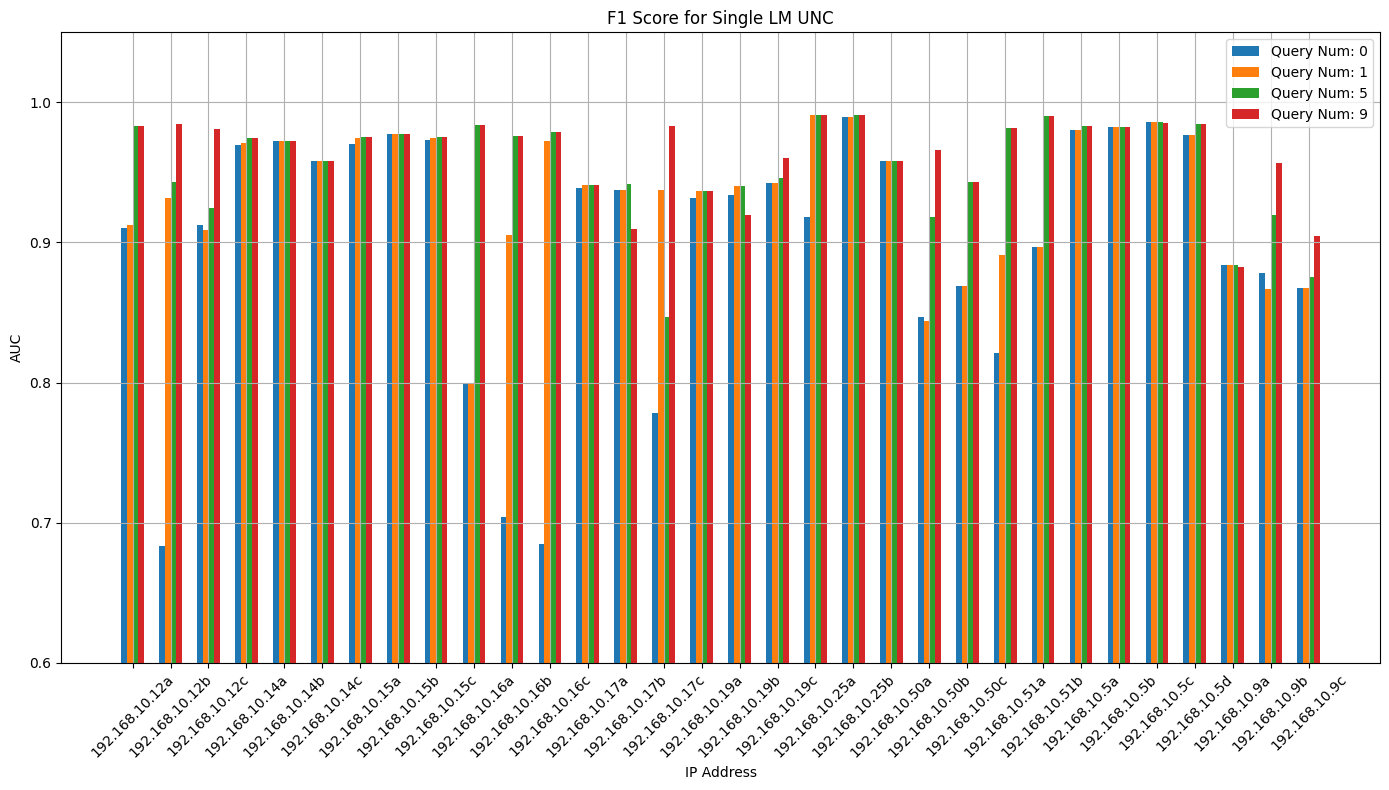

0.9647071177627413

In [73]:
plot_graph_scenario(metrics_dict, queries_iter = [0,1,5,9], title="F1 Score for Single LM UNC")
metric_values = []

for test_ip in metrics_dict['metric']:
    metric_values.append(metrics_dict['metric'][test_ip][9])

average_metric = np.mean(metric_values)
average_metric

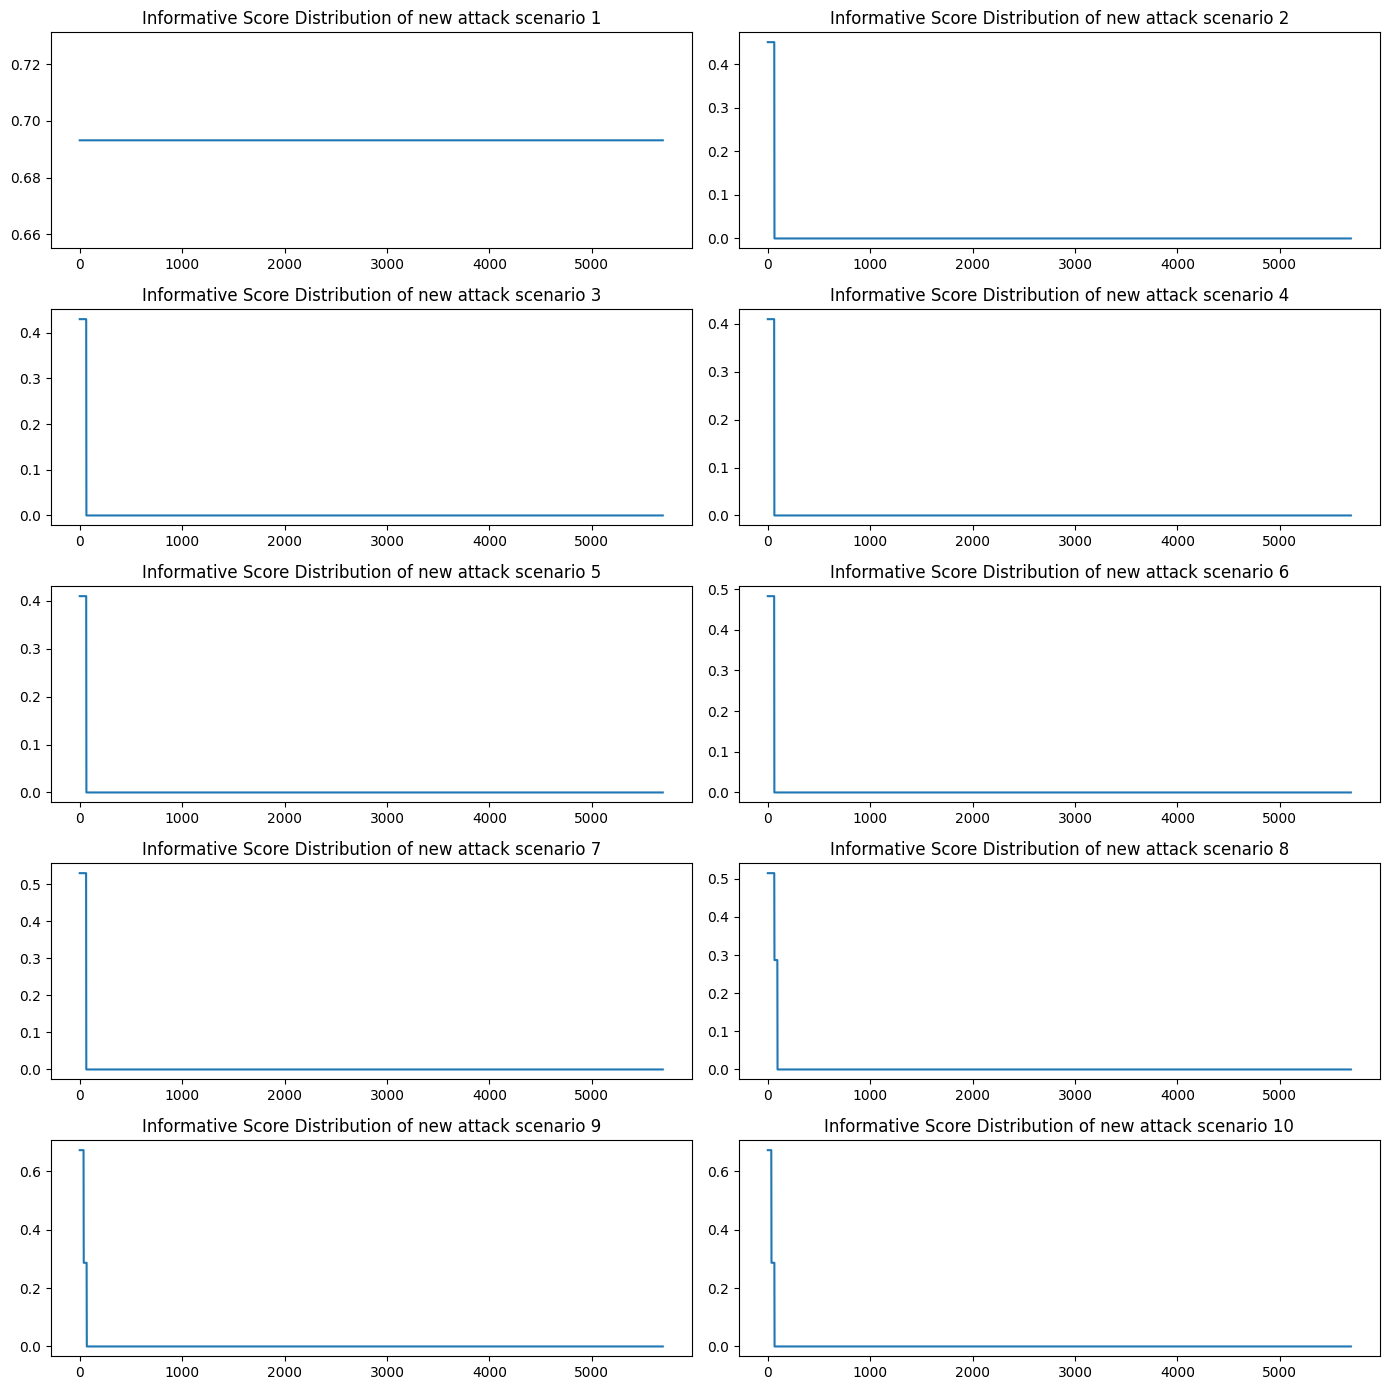

In [ ]:
plot_supporting_scores(metrics_dict['informative_score']["192.168.10.12a"], n_times=10)

In [65]:
metrics_dict['size']["192.168.10.12a"]

{0: 1506,
 1: 1528,
 2: 1550,
 3: 1572,
 4: 1625,
 5: 1678,
 6: 1731,
 7: 1784,
 8: 1837,
 9: 1890}

New Attack is not applicable to Scenario 2 but we can evaluate how small model affect active learning 

In [ ]:
last_ip = ip
last_ip

'192.168.10.9c'

In [69]:
# Evaluating One LM
X_known = Xrw_train_scaled[label_ind]
y_known = yrw_train[label_ind]
X_new_scaled_train, X_new_scaled_test, y_new_train, y_new_test = train_test_split(X_new_scaled, Y_new, shuffle=True, test_size=0.2,
                                                                                  stratify=Y_new, random_state=4022)
X = np.concatenate([X_known, X_new_scaled_train])
y = np.concatenate([y_known, y_new_train])
new_label_ind = np.arange(len(X_known))
new_unlab_ind = np.arange(len(X_known), len(X))
divided_arrays = np.array_split(new_unlab_ind, 10)

alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None,)
alibox_new.split_AL(test_ratio=0.1, initial_label_rate=0.1, split_count=50)
new_strategy = alibox_new.get_query_strategy(strategy_name=strategy_name)
label_size = [len(new_label_ind)]
for i in range(10):
  informative_score, query_accuracy, label_ind, model = evaluate_new_atk(X, y, new_strategy, alibox_new, i, X_new_scaled_test, 
                                                                                    y_new_test, new_label_ind, divided_arrays[i], 
                                                                                    model, metric, threshold = 0.1)
  new_label_ind = label_ind
  print(query_accuracy)
# informative_score_list.append(unc_informative_score)
# unc_queries_accuracy.append(unc_query_accuracy)
  label_size.append(np.shape(new_label_ind)[0])

([array([45944, 40669, 23369, ..., 42600, 23259,  1825]),
  array([37084,  6943, 38111, ..., 51192, 12649, 33866]),
  array([18690, 10636, 13362, ..., 11152, 15576, 44870]),
  array([44992, 57395, 20785, ..., 32442,  1821, 21578]),
  array([46573, 57383, 24159, ..., 42275, 32994,  5163]),
  array([12249,  9380, 57644, ..., 21970, 11873, 47137]),
  array([35149, 45030, 17246, ..., 22896, 13554, 14865]),
  array([42154,  2873, 41369, ..., 16441, 20869, 44582]),
  array([ 2377, 29723, 18985, ..., 59840, 41848,  1984]),
  array([38771, 27232, 24045, ...,    40,  5118, 36263]),
  array([19566, 28837, 57024, ...,   101, 20717,  3057]),
  array([39853, 41858, 52110, ..., 56852, 33392, 39963]),
  array([47878,  2889, 30180, ..., 33699, 53493,  2898]),
  array([17387, 48985, 27677, ..., 37570, 34714,  4531]),
  array([53175, 11329, 58297, ..., 54508, 12160, 56314]),
  array([19913, 42826, 32995, ...,  1317,  9230, 18131]),
  array([44128,  4264, 26860, ..., 21534, 21300, 42264]),
  array([54811

3140
Added 3140 Shape of Label_ind: (5588,)
0.9536351165980795
3167
Added 3167 Shape of Label_ind: (8755,)
0.9555096418732782
3029
Added 3029 Shape of Label_ind: (11784,)
0.956186277211353
3040
Added 3040 Shape of Label_ind: (14824,)
0.956186277211353
3022
Added 3022 Shape of Label_ind: (17846,)
0.954592292367933
3093
Added 3093 Shape of Label_ind: (20939,)
0.954592292367933
3067
Added 3067 Shape of Label_ind: (24006,)
0.9556940354721634
3003
Added 3003 Shape of Label_ind: (27009,)
0.955890410958904
2995
Added 2995 Shape of Label_ind: (30004,)
0.9555967332372521
3044
Added 3044 Shape of Label_ind: (33048,)
0.9560748303981361


Text(0.5, 1.0, 'Label Size Per Query')

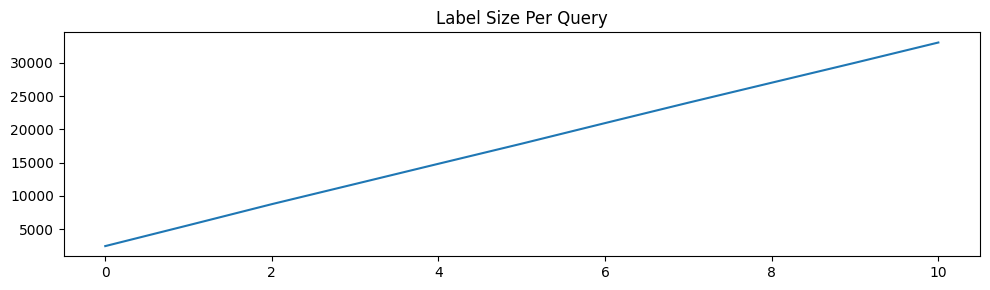

In [70]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(np.arange(len(label_size)), label_size)
ax.set_title("Label Size Per Query")
plt.tight_layout()
plt.show()


### Scenario 3

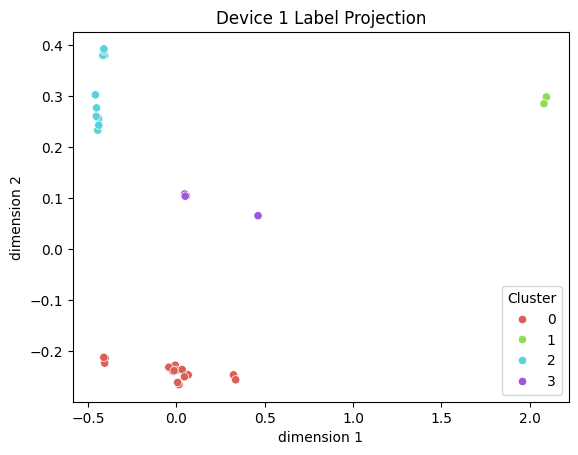

 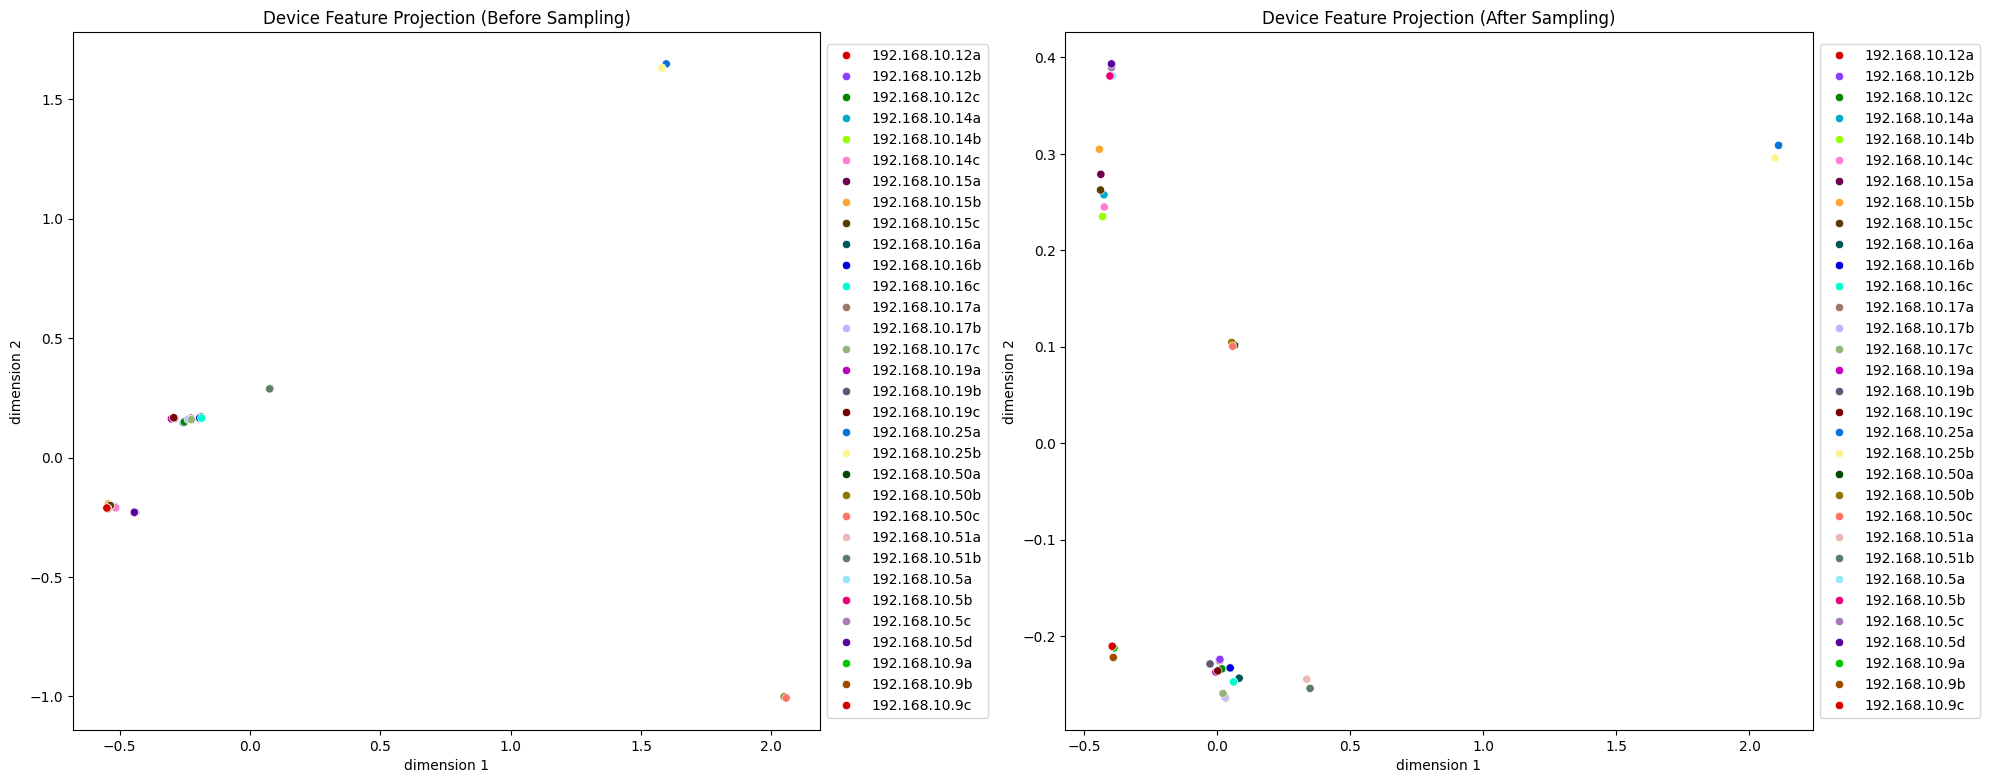

In [118]:
cluster_dict = {
  0: ['192.168.10.12a', '192.168.10.12b', '192.168.10.12c', '192.168.10.16a',
       '192.168.10.16b', '192.168.10.16c', '192.168.10.17a', '192.168.10.17b',
       '192.168.10.17c', '192.168.10.19a', '192.168.10.19b', '192.168.10.19c',
       '192.168.10.51a', '192.168.10.51b'],
  1: ['192.168.10.9a', '192.168.10.9b',
       '192.168.10.9c'],
  2: ['192.168.10.25a', '192.168.10.25b'],
  3: ['192.168.10.14a', '192.168.10.14b', '192.168.10.14c', '192.168.10.15a',
       '192.168.10.15b', '192.168.10.15c', '192.168.10.5a', '192.168.10.5b',
       '192.168.10.5c', '192.168.10.5d'],
  4: ['192.168.10.50a', '192.168.10.50b', '192.168.10.50c'] #New Atk belongs to the 3rd cluster
}

In [119]:
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']
anomaly_rate = 0.05
Xrw_train, Xrw_test, yrw_train, yrw_test, scaler = process_dataset(new_victim_df, anomaly_rate, train_perc=0.8)

Xrw_train.drop(columns=dropping_cols, axis=1, inplace=True)
Xrw_train_scaled = scaler.transform(Xrw_train)
Xrw_test_scaled = Xrw_test.drop(columns=dropping_cols, axis=1, inplace=False)
Xrw_test_scaled = scaler.transform(Xrw_test_scaled)
yrw_train = yrw_train.values
yrw_test = yrw_test.values
round = 10
metrics_dict = {
    'metric': {ip : {query : 0 for query in range(round)} for ip in new_victim_IP},
    'informative_score': {cluster : {query : [] for query in range(round)} for cluster in cluster_dict.keys()},
    'size': {cluster : {query : 0 for query in range(round)} for cluster in cluster_dict.keys()}
}      

In [94]:
len(cluster_dict[0])

17

In [109]:
import random

random.seed(42)  # Set seed for random operations
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [120]:
for cluster in cluster_dict.keys():
  victim_IP = cluster_dict[cluster]
  batch_size = min(len(victim_IP)*300,10000)
  curr_cluster_df = new_victim_df.loc[new_victim_df["Dvc Label"].isin(victim_IP)]
  X_curr_train, X_curr_test, y_curr_train, y_curr_test, _ = process_dataset(curr_cluster_df, anomaly_rate = 0.05, train_perc=0.8)
  X_curr_train_scaled, X_curr_test_scaled = X_curr_train.drop(columns=dropping_cols, axis=1, inplace=False), X_curr_test.drop(columns=dropping_cols, axis=1, inplace=False),
  X_curr_train_scaled, X_curr_test_scaled = scaler.transform(X_curr_train_scaled), scaler.transform(X_curr_test_scaled)
  y_curr_train, y_curr_test = y_curr_train.values, y_curr_test.values  
  # Set Data Split for 10 Batches
  alibox = ToolBox(X=X_curr_train_scaled, y=y_curr_train, query_type='AllLabels', saving_path=None)
  alibox.split_AL(test_ratio=0.99, initial_label_rate=0.03, split_count=10)
  strategy_name = "QueryInstanceUncertainty"
  strategy = alibox.get_query_strategy(strategy_name=strategy_name)
  _, x, label_ind, _ = alibox.get_split(0)
  
  lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)
  metric = f1_score
  # label_ind = np.concatenate([label_ind, [np.where(y_curr_train == 1)[0][0]]]) #Make Sure 2 classes exists
  lm_clf.fit(X_curr_train_scaled[label_ind,:], y_curr_train[label_ind])
  initial_acc = metric(lm_clf.predict(X_curr_test_scaled), y_curr_test)
  informative_score_list = []
  queries_accuracy = [initial_acc]
  label_size = [np.shape(label_ind)[0]]  
  for i in range(round):
    informative_score, query_accuracy, label_ind, model    = batch_train(X_curr_train_scaled, y_curr_train, 
                                  strategy, alibox, i, X_curr_test_scaled, y_curr_test, label_ind, lm_clf, metric, threshold = 0.1, batch_size = batch_size )
    # metrics_dict['metric'][cluster][i] = query_accuracy
    metrics_dict['size'][cluster][i] = len(label_ind)
    metrics_dict['informative_score'][cluster][i] = informative_score
    metrics_dict = evalute_all_dvc(victim_IP, Xrw_test, y_test, model, scaler, metric, i, metrics_dict)
  # break
  
  

([array([44722, 44403, 73237, 73965, 72551,   219, 63168, 67460, 16231,
         44653, 22557,  3187, 39943, 53499, 75364, 21449, 28781, 32613,
          5913, 31899, 33609, 25605, 57249, 41227, 17589, 29729, 60373,
         14813, 30221,   895, 36677, 76351, 12538, 13103, 13979, 63370,
         26599, 47625,  4076, 74739, 50817, 53267, 13313, 35244, 65423,
         15802, 30871, 75834,  9995, 46268, 77602, 62199, 56306, 25680,
         15154, 27206, 17128, 63986, 63384, 74384, 58999, 46095, 63085,
         70754, 23606,  3312, 71016, 74680, 51343, 56003, 17219, 53802,
         15495, 45875,  3673,  4260, 40365, 46021, 22003,  2470,  2066,
         70858, 10060, 19875,  6117, 41192, 38542, 38276, 43580, 67054,
         38180, 75452, 11389, 20164, 26410, 16121, 76560, 14197, 64601,
         27240,  7746, 15837, 57732, 24137, 64860,  9912, 16499, 33216,
         67010,   185,  4596, 44155, 61993, 22061, 51426, 48042, 11021,
         57941, 55943, 22408, 57808, 51511,  4132, 30811, 54673,

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

4200
Added 4200 Shape of Label_ind: (4223,)
608
Added 608 Shape of Label_ind: (4831,)
393
Added 393 Shape of Label_ind: (5224,)
329
Added 329 Shape of Label_ind: (5553,)
299
Added 299 Shape of Label_ind: (5852,)
300
Added 300 Shape of Label_ind: (6152,)
291
Added 291 Shape of Label_ind: (6443,)
290
Added 290 Shape of Label_ind: (6733,)
277
Added 277 Shape of Label_ind: (7010,)
258
Added 258 Shape of Label_ind: (7268,)


([array([ 7351,  9368, 18175,  6816, 19328,  2576, 17166, 14445,  2673,
         10318,   472,  7975, 14299,  6712,  8757,  2197,  5575,   420,
         17452, 16151, 17576, 20367, 12779, 19520, 13476, 17896, 14998,
          6691, 19145,  6859,  3047, 16450,  7321,  4164,  5546,   733,
         13677,  4681, 10534, 12533, 17126,  1704, 18910,  8991, 10351,
          3651,  5934,  8038,  7329,  3922,  6051,  3475, 14348, 14223,
         13938, 13178,  8534,  6915, 12221,  6075, 16865,  7658, 18373,
          1578, 14235, 10040,  8595, 18217, 10291, 13134, 19448,  3725,
         19101,  5506, 10557, 10958, 17749, 17100,  9938,  6813,  4693,
          2309,  2120, 10382, 12780, 13921,  6591,  6849,  4217, 19681,
         19557,  6004, 17442, 16014,  3579,  2269,  5084,  2333,  8559,
         19825,  2853, 11777,  2659, 14077,  4571, 10950, 12756, 17816,
         16881,  2067,  5419, 11569, 10224,   995, 18709, 18608, 10515,
          1522,  7522, 15591, 16984,  4385,  2638, 16259, 11611,

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

900
Added 900 Shape of Label_ind: (906,)
871
Added 871 Shape of Label_ind: (1777,)
260
Added 260 Shape of Label_ind: (2037,)
606
Added 606 Shape of Label_ind: (2643,)
374
Added 374 Shape of Label_ind: (3017,)
377
Added 377 Shape of Label_ind: (3394,)
276
Added 276 Shape of Label_ind: (3670,)
208
Added 208 Shape of Label_ind: (3878,)
213
Added 213 Shape of Label_ind: (4091,)
263
Added 263 Shape of Label_ind: (4354,)


([array([ 2619, 13977,   189,  4498,   185,  4049,  4893,    78,  9156,
          4923,  4007, 11099,  1335,  6073, 12434, 13857,  7118,   592,
          2927, 11936,  9493,  9059,  5492, 11109,  4419, 12264,  9711,
          1002,  1557,  2341,  1935,  5796,  5709,  5438, 11399,  9405,
         13585,   818, 13615,  2717,  2318,  3235,  8151,  5240, 10466,
          6665,  3818,  9598,  1729, 11325, 11622,  8051, 11518, 11917,
         10156,  3097,  6204,  2978,  3181, 10476,  1734,  7674, 13739,
          5666,  7454, 11888,  5264,  3886,  3775, 11295,  7346,  2192,
          4951, 10490, 13932,  9544,  3344,  2823, 11402, 11798,  9287,
           811,  4774, 10947,  4496,  9876,  6471,  5625,  1775, 12673,
         13380,  6199,  1657,  9301, 12141,  1161, 11687, 10066, 11802,
          8639,   294,  3776, 13358,  6136,  8270, 10133,  7860,  5348,
          3090,  5195,   591,  5066, 12284,  8694,  7753,  3126,   769,
          7693,  6082, 12753,  2732, 11028,  4114,  3608,  9176,

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

600
Added 600 Shape of Label_ind: (604,)
209
Added 209 Shape of Label_ind: (813,)
199
Added 199 Shape of Label_ind: (1012,)
146
Added 146 Shape of Label_ind: (1158,)
126
Added 126 Shape of Label_ind: (1284,)
153
Added 153 Shape of Label_ind: (1437,)
132
Added 132 Shape of Label_ind: (1569,)
124
Added 124 Shape of Label_ind: (1693,)
112
Added 112 Shape of Label_ind: (1805,)
107
Added 107 Shape of Label_ind: (1912,)


([array([ 3027, 27644, 11470, 10433, 42835, 51695, 44749, 64005, 46145,
         34433, 28655, 61281, 54838,  1778, 47498, 60818, 63550, 59249,
         31622, 17189,  2964, 34699, 17777, 31987, 48392,   245, 30117,
         17863, 26392, 42548, 23689, 49366, 57820, 35362, 57336, 31268,
         47070, 27910, 61609,  6006, 52961, 46417,  6393, 35287,  5907,
         53464, 55732, 60787,  2668, 16920, 25173, 58005, 41532, 42480,
         14872, 38719, 31594, 30253, 27818, 60689,  5105, 39610, 38174,
         49721, 16417, 42459, 42558, 49540, 58146, 24603,  3243, 13597,
          3381,  2027,   199, 51515,  8875, 47403, 37372, 38950, 36743,
         21854, 40392, 42443, 31043, 64030, 49045, 10213, 41708, 30576,
         23359, 57591,  5127, 27939, 62999, 41511, 19213, 26134, 40311,
          8869,   687, 22094, 48097, 21492,  3105, 25684, 39104, 36826,
         36215, 45206, 13072,  7633, 61354, 31620, 32096, 49435, 11603,
         54177, 38356,  8825, 40883, 61839, 22805, 42933,   538,

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

3000
Added 3000 Shape of Label_ind: (3019,)
216
Added 216 Shape of Label_ind: (3235,)
155
Added 155 Shape of Label_ind: (3390,)
126
Added 126 Shape of Label_ind: (3516,)
125
Added 125 Shape of Label_ind: (3641,)
110
Added 110 Shape of Label_ind: (3751,)
108
Added 108 Shape of Label_ind: (3859,)
110
Added 110 Shape of Label_ind: (3969,)
110
Added 110 Shape of Label_ind: (4079,)
109
Added 109 Shape of Label_ind: (4188,)


([array([4119,   72,  772, 1295,   19, 2000, 3859, 1514, 1716,  112, 2069,
         5189, 3791, 4080, 4477, 5059,  358, 4594, 4283, 1080, 2528, 1504,
         4252, 3431, 2713, 4183, 4452, 2386, 5101, 1711, 1842, 4980, 1537,
         2084, 5205, 3665, 2769, 2265,  306,  556, 3304, 5181, 1654, 4905,
         2900, 1120, 2331, 3607, 4589, 3332, 4642, 3525,  981,  897, 4627,
         4991, 2470]),
  array([1597, 3837, 1740, 1241, 3613, 4969, 1444,  387, 1943,  895,  765,
         4297, 3900, 4175, 3418,   21, 3954,  787, 4903,  491,    6, 2103,
         4396, 3951,    9, 1219, 1465, 1799, 3089, 3068,  647, 2086, 3892,
         4654, 3406,  560, 3884, 2774, 1311, 1536, 4293, 3155, 3777, 3098,
         2181, 4395, 3560, 1090, 2225, 3048, 2811, 4907,   60, 2889, 4117,
          439, 4110]),
  array([3442, 2844,  675, 4736, 4714, 4681, 3552, 1699,  808, 2673, 2440,
          898, 1424, 3019, 1330,  433, 4494, 4138, 3036, 2121, 2416, 3026,
         4933,  948, 5640, 2030, 4898, 3783,  956, 494

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

900
Added 900 Shape of Label_ind: (902,)
48
Added 48 Shape of Label_ind: (950,)
48
Added 48 Shape of Label_ind: (998,)
48
Added 48 Shape of Label_ind: (1046,)
39
Added 39 Shape of Label_ind: (1085,)
39
Added 39 Shape of Label_ind: (1124,)
38
Added 38 Shape of Label_ind: (1162,)
37
Added 37 Shape of Label_ind: (1199,)
39
Added 39 Shape of Label_ind: (1238,)
39
Added 39 Shape of Label_ind: (1277,)


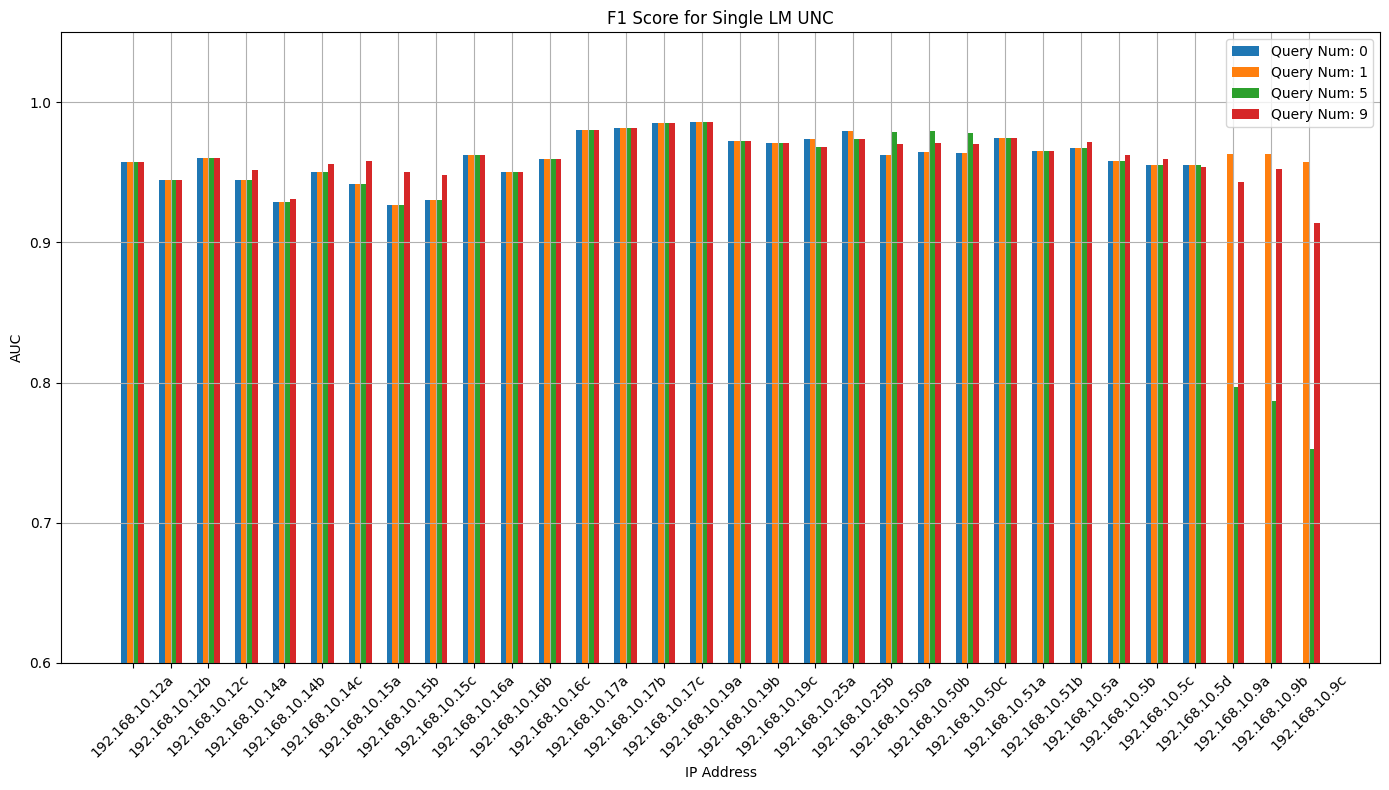

0.9611455869378015

In [121]:
plot_graph_scenario(metrics_dict, queries_iter = [0,1,5,9], title="F1 Score for Single LM UNC")
metric_values = []

for test_ip in metrics_dict['metric']:
    metric_values.append(metrics_dict['metric'][test_ip][9])

average_metric = np.mean(metric_values)
average_metric

In [122]:
# Evaluating Cluster_3's LM


X_known = Xrw_train_scaled[label_ind]
y_known = yrw_train[label_ind]
X_new_scaled_train, X_new_scaled_test, y_new_train, y_new_test = train_test_split(X_new_scaled, Y_new, shuffle=True, test_size=0.2,
                                                                                  stratify=Y_new, random_state=4022)
X = np.concatenate([X_known, X_new_scaled_train])
y = np.concatenate([y_known, y_new_train])
new_label_ind = np.arange(len(X_known))
new_unlab_ind = np.arange(len(X_known), len(X))
divided_arrays = np.array_split(new_unlab_ind, 10)

alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None,)
alibox_new.split_AL(test_ratio=0.1, initial_label_rate=0.1, split_count=50)
new_strategy = alibox_new.get_query_strategy(strategy_name=strategy_name)
label_size = [len(new_label_ind)]
for i in range(10):
  informative_score, query_accuracy, label_ind, model = evaluate_new_atk(X, y, new_strategy, alibox_new, i, X_new_scaled_test, 
                                                                                    y_new_test, new_label_ind, divided_arrays[i], 
                                                                                    model, metric, threshold = 0.1)
  new_label_ind = label_ind
  print(query_accuracy)
# informative_score_list.append(unc_informative_score)
# unc_queries_accuracy.append(unc_query_accuracy)
  label_size.append(np.shape(new_label_ind)[0])

([array([51757, 44374, 51020, ..., 47381, 44248, 58791]),
  array([25856, 55207, 51927, ...,  9965, 41629, 12371]),
  array([40749,  8062, 32803, ..., 51380, 13959, 46129]),
  array([32885,  2723, 11933, ..., 21827, 29849, 34471]),
  array([22282,  4747, 58029, ..., 31987, 17191, 45717]),
  array([44103, 24576, 21638, ..., 16936, 51385, 56281]),
  array([ 4887, 25737, 12118, ..., 27414, 56867,  9920]),
  array([35122, 45226, 45572, ..., 29242, 47118, 12017]),
  array([ 5692, 40937, 43508, ..., 13854, 30056, 58536]),
  array([46946, 11712,  1437, ..., 18189,  6766, 14356]),
  array([29071,  2943, 31919, ..., 18273,  2904, 39408]),
  array([35916, 20673,  4048, ..., 22984,  2510, 50603]),
  array([22324, 12912, 42479, ...,  4487, 29380, 56007]),
  array([ 4593, 21157, 52353, ..., 22347,  8935, 38485]),
  array([50099,  9563, 50273, ...,  5450, 31874, 47019]),
  array([56604, 30315, 48703, ..., 55874, 12210, 37844]),
  array([ 5799, 30506, 13831, ..., 15119, 50457, 17531]),
  array([ 1702

243
Added 243 Shape of Label_ind: (1520,)
0.9346127484578478
1827
Added 1827 Shape of Label_ind: (3347,)
0.953776310359059
3140
Added 3140 Shape of Label_ind: (6487,)
0.9561143644505683
3059
Added 3059 Shape of Label_ind: (9546,)
0.9555830583058306
3020
Added 3020 Shape of Label_ind: (12566,)
0.9555830583058306
3084
Added 3084 Shape of Label_ind: (15650,)
0.9564023343631994
3094
Added 3094 Shape of Label_ind: (18744,)
0.9572637808822517
3005
Added 3005 Shape of Label_ind: (21749,)
0.9577232419055475
3045
Added 3045 Shape of Label_ind: (24794,)
0.9581989155055254
3031
Added 3031 Shape of Label_ind: (27825,)
0.9581989155055254


Text(0.5, 1.0, 'Label Size Per Query')

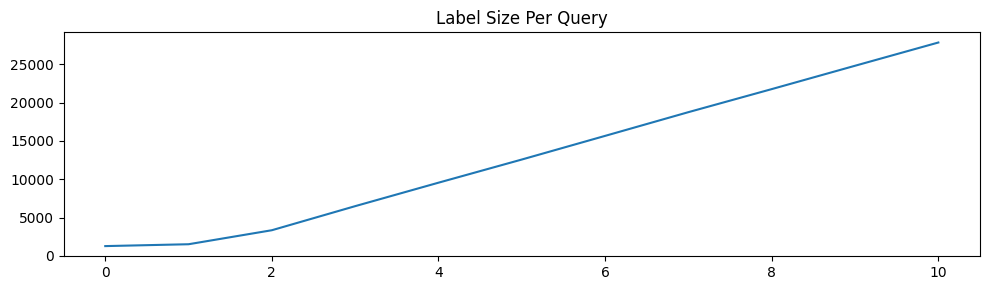

In [123]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(np.arange(len(label_size)), label_size)
ax.set_title("Label Size Per Query")
plt.tight_layout()
plt.show()


In [21]:
len(X)

58806